# Machine learning-based mineral prospectivity mapping

### Ehsan Farahbakhsh, R. Dietmar M&uuml;ller

*EarthByte Group, School of Geosciences, University of Sydney, Sydney, Australia*

This notebook enables the user to create a mineral prospectivity map in New South Wales, particularly the Lachlan Orogen. It comprises two main sections; in the first section, the available datasets are visualised, and in the second section, machine learning algorithms are applied to create a prospectivity map.

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cmcrameri.cm as cmc
from collections import deque
import contextily as cx
import geopandas as gpd
from ipywidgets import interact
from lib_mpm import *
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from numpy import genfromtxt
from osgeo import gdal
from osgeo import osr
import os
import pandas as pd
import pickle
from pulearn import BaggingPuClassifier
import rioxarray as rxr
from scipy import ndimage, stats
from scipy.interpolate import griddata#, make_interp_spline
from shapely.strtree import STRtree
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer

### Mineral Occurrences

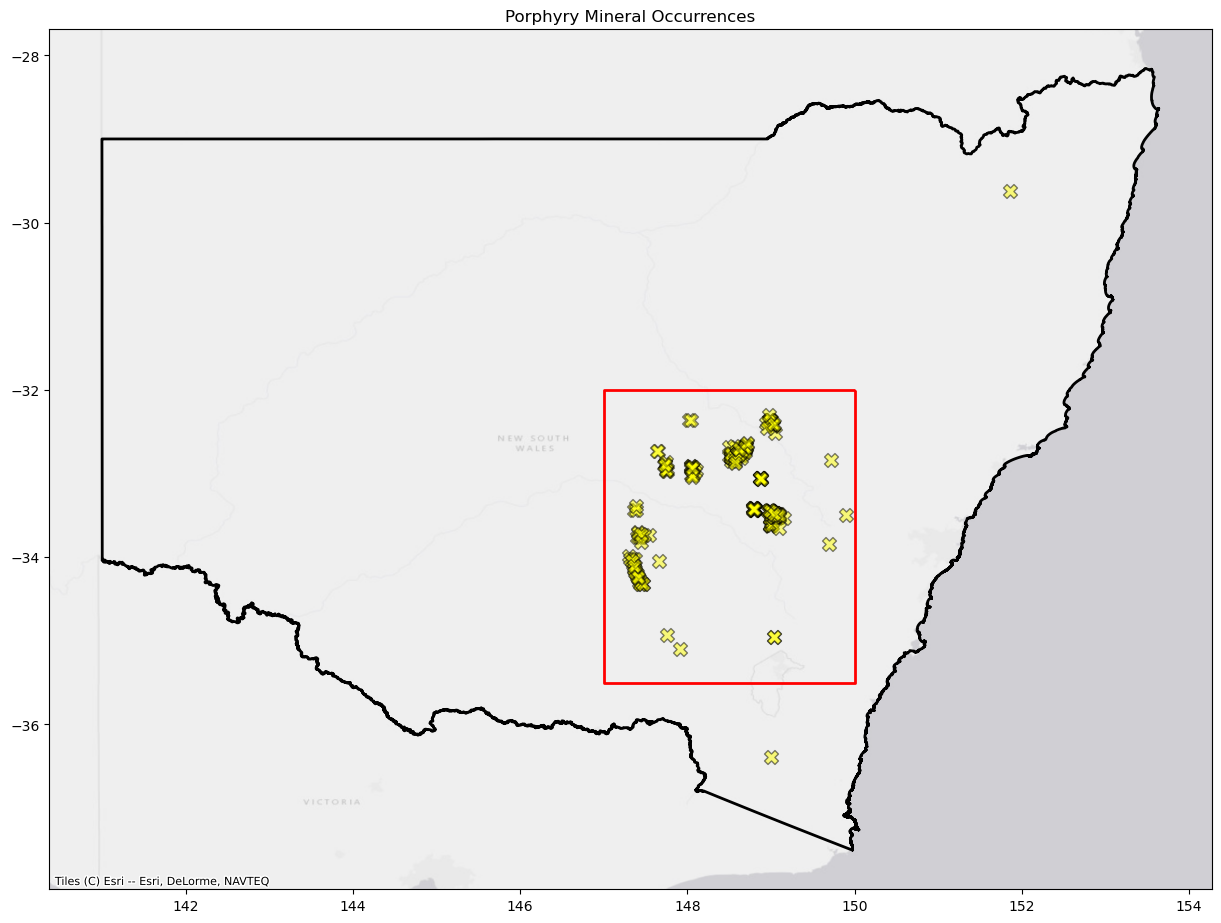

In [2]:
min_occ = gpd.read_file('./Datasets/Mineral Occurrences/MinView/GSNSWDataset/porphyry.shp')
nsw_bndy = gpd.read_file('./Datasets/Frames/NSW_Boundary/NSW_STATE_POLYGON_shp_GDA94_NoIsland_ACT.shp')
frame_target = gpd.read_file('./Datasets/Frames/Lachlan_Boundary_edited.shp')

bounds = nsw_bndy.bounds
extent = [bounds.loc[0]['minx'], bounds.loc[0]['maxx'], bounds.loc[0]['miny'], bounds.loc[0]['maxy']]

bounds_target = frame_target.bounds
extent_target = [bounds_target.loc[0]['minx'], bounds_target.loc[0]['maxx'], bounds_target.loc[0]['miny'], bounds_target.loc[0]['maxy']]

fig, ax = plt.subplots(figsize=(15, 15))
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Porphyry Mineral Occurrences')
plt.show()

### Vector Data Layers

#### Intrusion Boundaries

In [3]:
intrusion_bndy_files = [
    './Datasets/Geology/Polylines/IntrusionsBndys_FaultedBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_GeologicalBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_IntrusiveBndys.shp',
    './Datasets/Geology/Polylines/IntrusionsBndys_UnconformableBndys.shp'
]

@interact(dataset=intrusion_bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Intrusion Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/IntrusionsBndys_F…

#### Metamorphic Boundaries

In [4]:
metamorphic_bndy_files = [
    './Datasets/Geology/Polylines/MetamorphicBoundaries_Faults.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_GeologicalBndys.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_MetamorphicBndys.shp',
    './Datasets/Geology/Polylines/MetamorphicBoundaries_Unconformities.shp'
]

@interact(dataset=metamorphic_bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Metamorphic Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/MetamorphicBounda…

#### Metamorphic Isograds

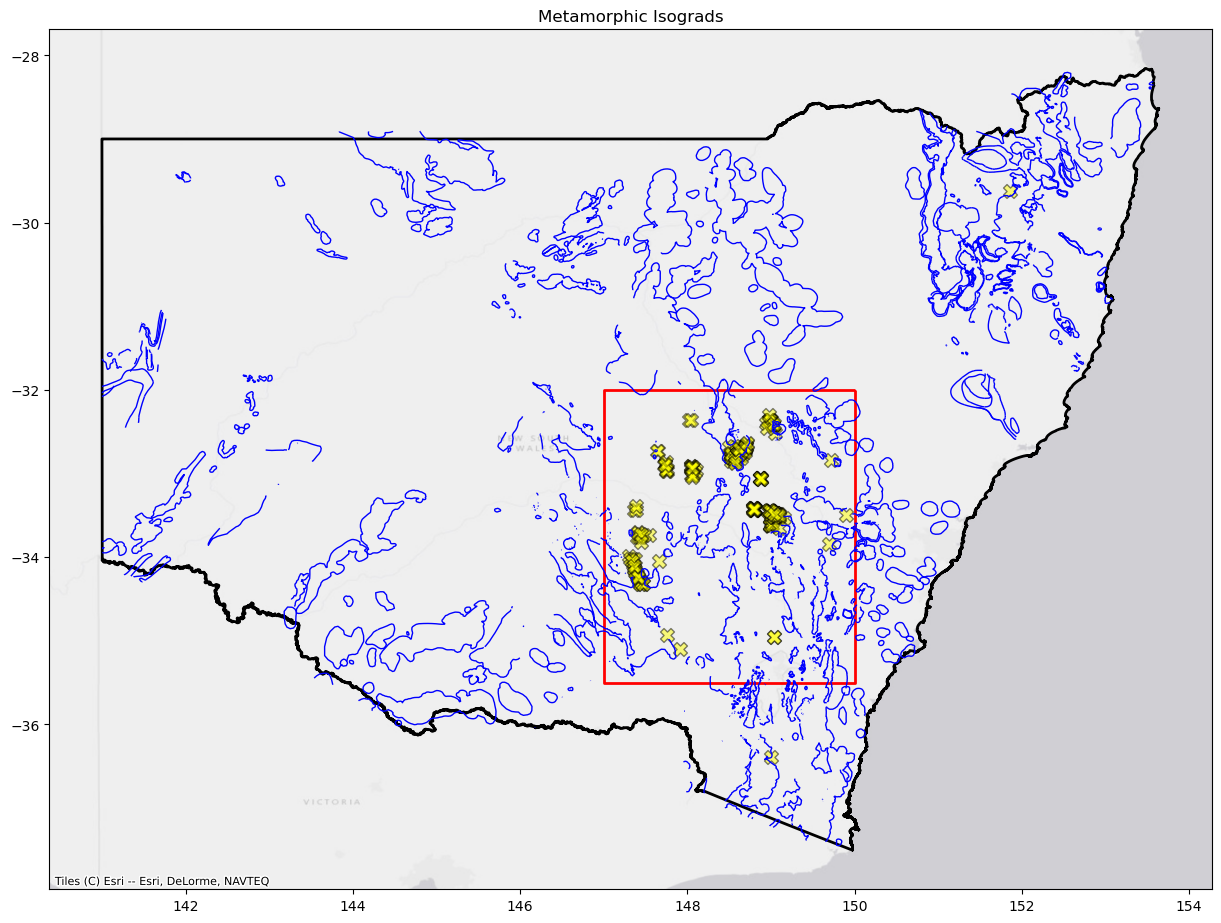

In [5]:
metamorphic_iso_file = './Datasets/Geology/Polylines/MetamorphicIsograds.shp'
metamorphic_iso = gpd.read_file(metamorphic_iso_file)

fig, ax = plt.subplots(figsize=(15, 15))
metamorphic_iso.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Metamorphic Isograds')
plt.show()

#### Rock Units, Boundaries, and Fault Layers

In [6]:
bndy_files = [
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Faulted boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Geological boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Intrusive boundary.shp',
    './Datasets/Geology/Polylines/RockUnitBndyFaults_LAO_Unconformable boundary.shp'
]

@interact(dataset=bndy_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    fig, ax = plt.subplots(figsize=(15, 15))
    data.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    ax.set_title('Faulted Boundaries')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polylines/RockUnitBndyFault…

#### Cluster Boundaries of Shear Wave Velocity

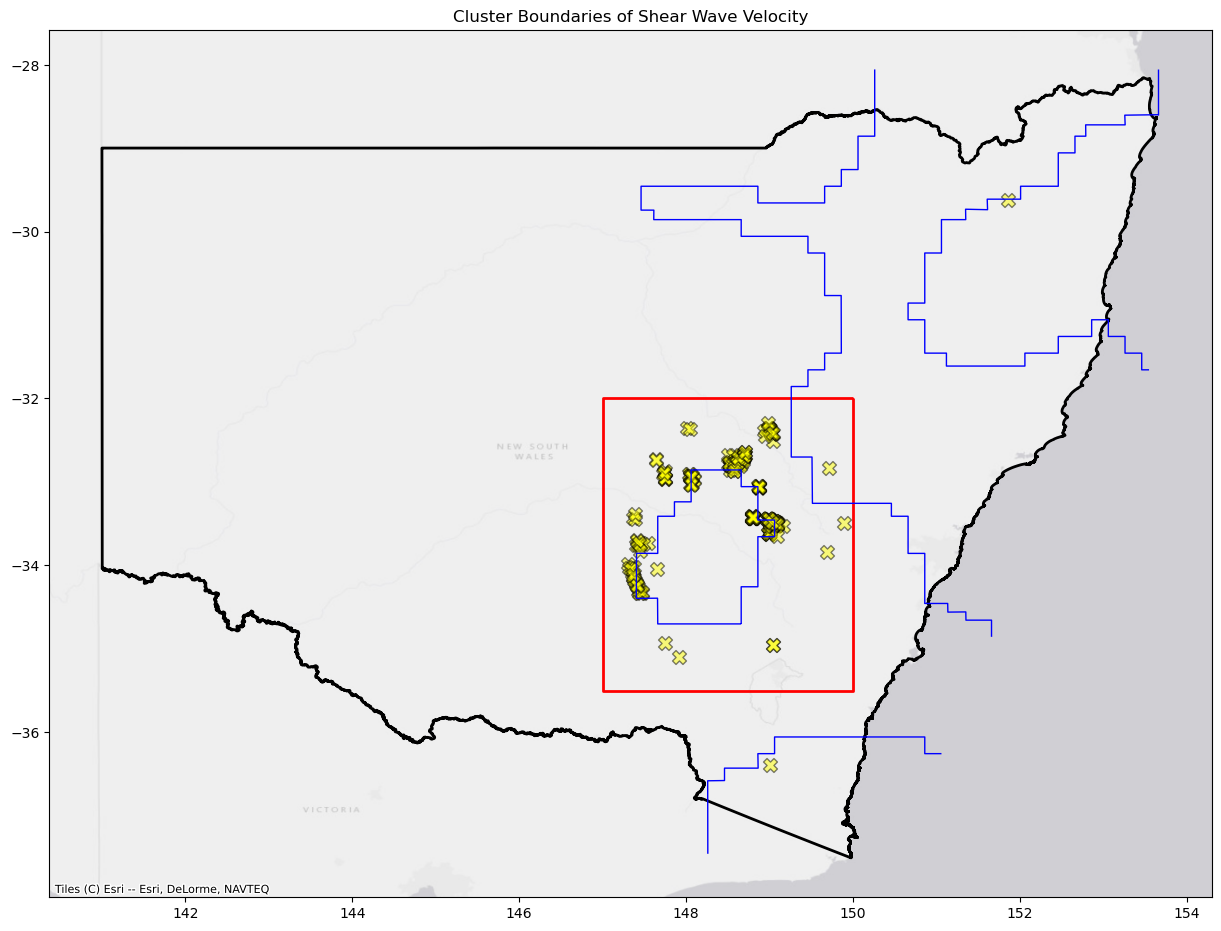

In [7]:
vs_cluster_file = './Datasets/Seismic/vs_cluster_boundaries.shp'
vs_cluster = gpd.read_file(vs_cluster_file)

fig, ax = plt.subplots(figsize=(15, 15))
vs_cluster.plot(ax=ax, edgecolor='none', color='blue', linewidth=1)
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Cluster Boundaries of Shear Wave Velocity')
plt.show()

#### Intrusions

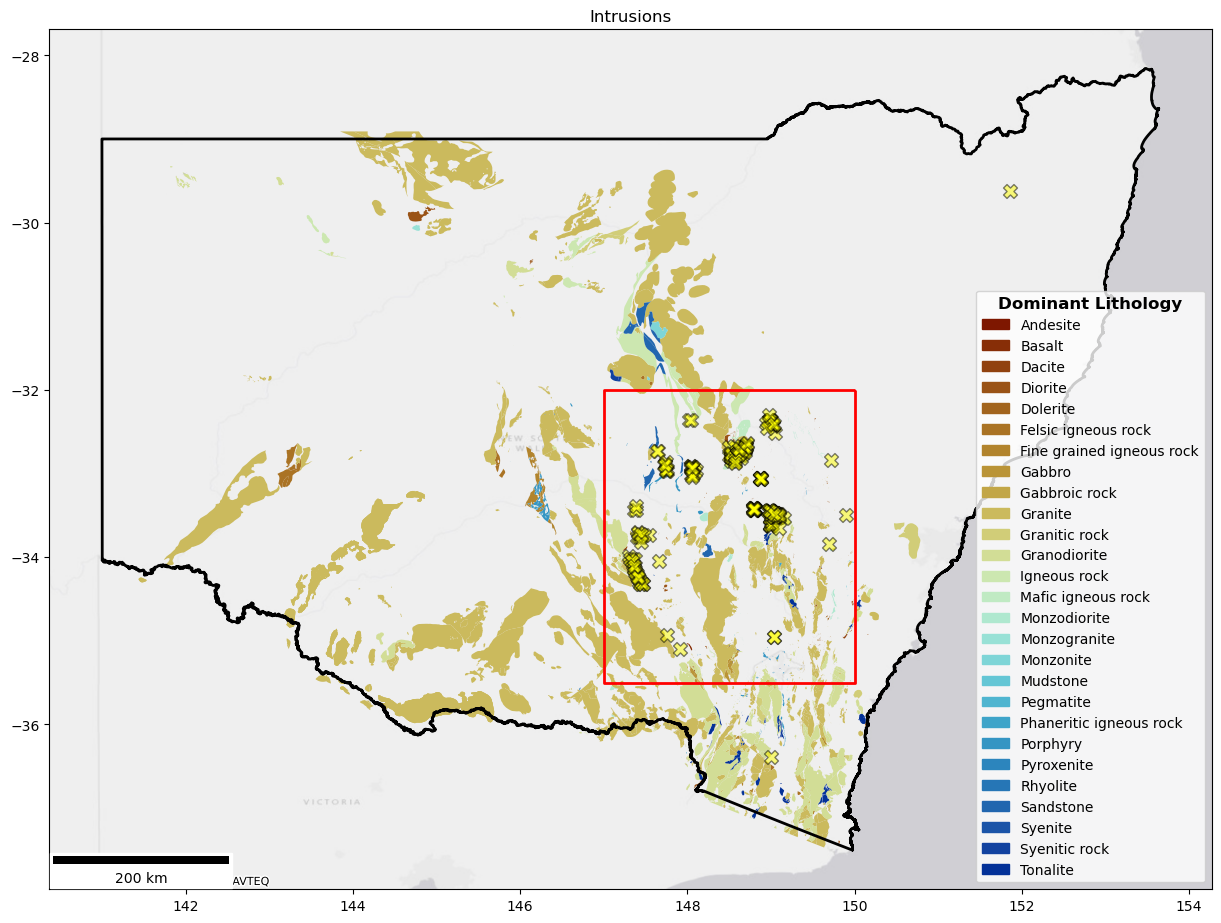

In [8]:
# Load the shapefile
intrusions_file = './Datasets/Geology/Polygons/Intrusions_Tabberabberan.shp'
intrusions = gpd.read_file(intrusions_file)

# Ensure there is a column to differentiate the geological units, for example 'unit'
# If 'unit' does not exist, replace 'unit' with the appropriate column name
intrusions_units = sorted(intrusions['Dominant_L'].unique()) # Sort the units alphabetically

# Generate a colorblind-friendly palette with cmc
cmap = cmc.roma  # Use the 'roma' colormap from cmcrameri
palette = cmap(np.linspace(0, 1, len(intrusions_units)))

# Create a dictionary mapping each geological unit to a unique color
unit_colors = {unit: palette[i] for i, unit in enumerate(intrusions_units)}

# Plot the shapefile with the assigned colors
fig, ax = plt.subplots(figsize=(15, 15))
for unit, color in unit_colors.items():
    subset = intrusions[intrusions['Dominant_L'] == unit]
    subset.plot(ax=ax, color=color)

nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

patches = [mpatches.Patch(color=color, label=unit) for unit, color in unit_colors.items()]

# Define font properties for the legend title
title_font = FontProperties(weight='bold', size=12)

# Create custom legend (inside)
plt.legend(handles=patches, loc='lower right', title='Dominant Lithology',
          title_fontproperties=title_font)

# Add a scale bar
scalebar = ScaleBar(95, units='km', dimension='si-length', location='lower left', length_fraction=0.2)  # Adjust units as needed
# For UTM based coordinate system, where the X and Y are in meters, simply set dx = 1.
# For WGS or NAD based coordinate system, where X and Y are in latitude (Y) and longitude (X),
# compute the distance between two points at the latitude (Y) you wish to have the scale represented and are also one
# full degree of longitude (X) apart, in meters. For example, dx = great_circle_distance((X, Y), (X + 1, Y))
ax.add_artist(scalebar)

plt.title('Intrusions')
plt.show()

#### Metamorphic Facies

In [9]:
meta_fac_files = [
    './Datasets/Geology/Polygons/MetamorphicFacies_Benambran.shp',
    './Datasets/Geology/Polygons/MetamorphicFacies_KanimblanTablelands.shp',
    './Datasets/Geology/Polygons/MetamorphicFacies_Tabberabberan.shp'
]

@interact(dataset=meta_fac_files)
def show_dist(dataset):
    data = gpd.read_file(dataset)
    data_units = sorted(data['MetFacies'].unique())
    cmap = cmc.roma
    palette = cmap(np.linspace(0, 1, len(data_units)))
    unit_colors = {unit: palette[i] for i, unit in enumerate(data_units)}

    fig, ax = plt.subplots(figsize=(15, 15))
    for unit, color in unit_colors.items():
        subset = data[data['MetFacies'] == unit]
        subset.plot(ax=ax, color=color)

    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
    min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    
    patches = [mpatches.Patch(color=color, label=unit) for unit, color in unit_colors.items()]

    title_font = FontProperties(weight='bold', size=12)

    plt.legend(handles=patches, loc='lower right', title='Metamorphic Facies',
              title_fontproperties=title_font)

    scalebar = ScaleBar(95, units='km', dimension='si-length', location='lower left', length_fraction=0.2)
    ax.add_artist(scalebar)

    plt.title('Metamorphic Facies')
    plt.show()

interactive(children=(Dropdown(description='dataset', options=('./Datasets/Geology/Polygons/MetamorphicFacies_…

#### Rock Units

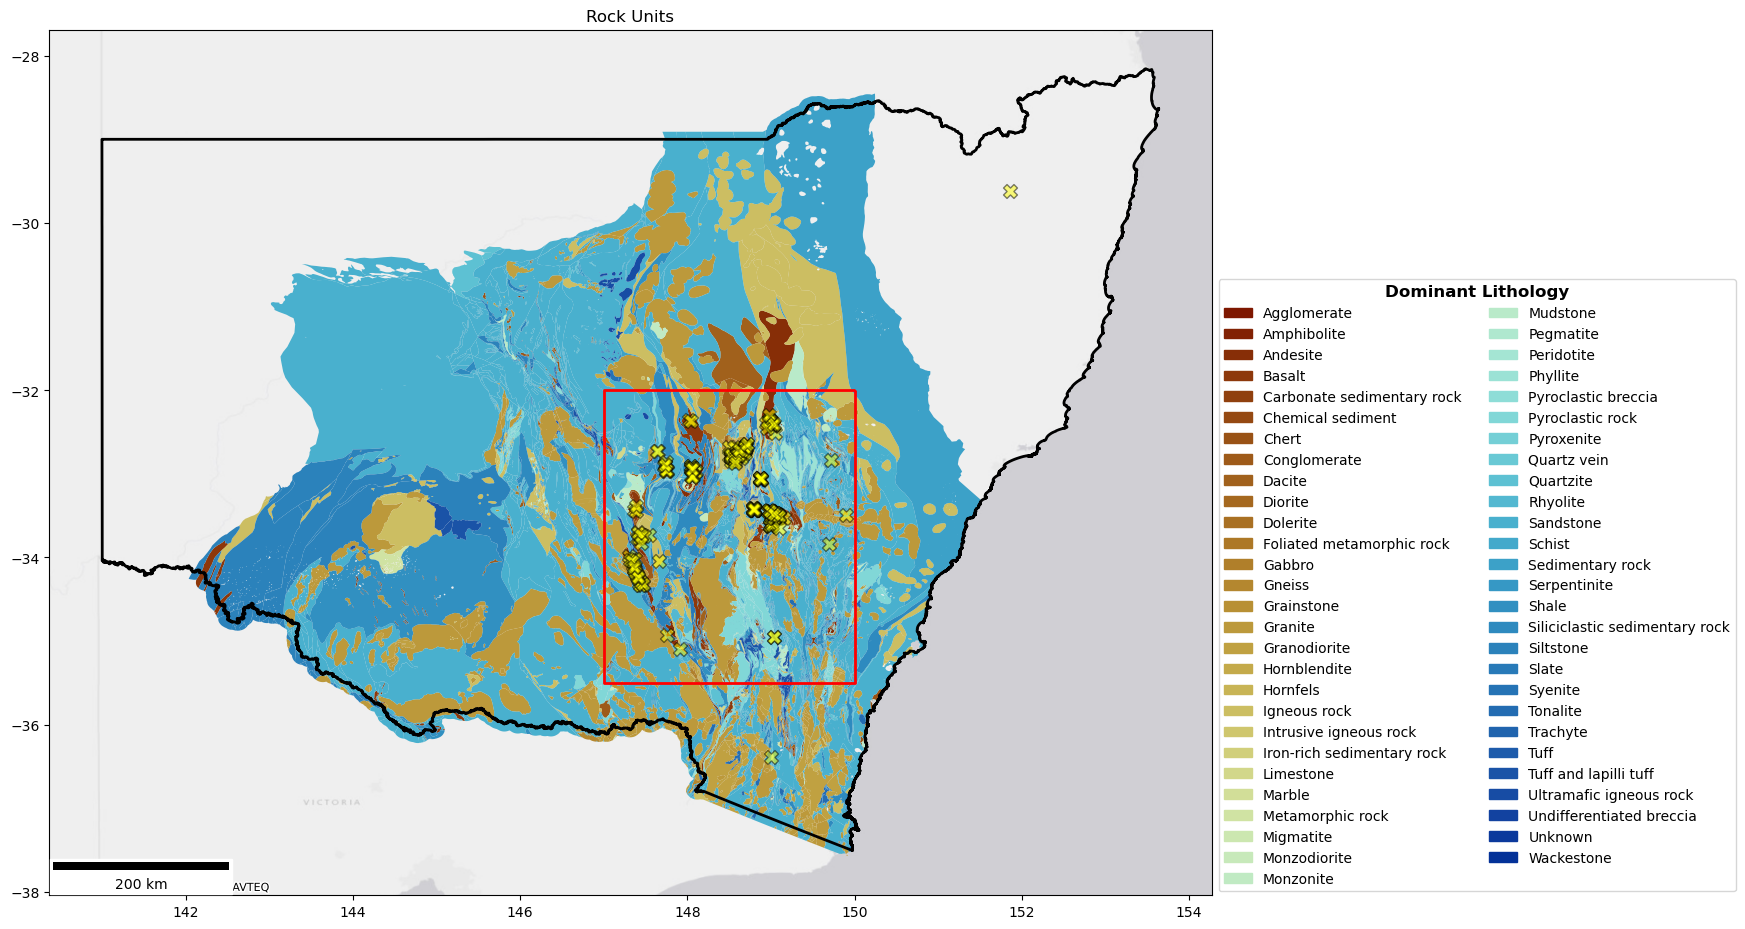

In [10]:
rock_units_file = './Datasets/Geology/Polygons/RockUnits_LAO.shp'
rock_units = gpd.read_file(rock_units_file)

rock_units_sorted = sorted(rock_units['Dominant_L'].unique())

cmap = cmc.roma
palette = cmap(np.linspace(0, 1, len(rock_units_sorted)))

unit_colors = {unit: palette[i] for i, unit in enumerate(rock_units_sorted)}

fig, ax = plt.subplots(figsize=(15, 15))
for unit, color in unit_colors.items():
    subset = rock_units[rock_units['Dominant_L'] == unit]
    subset.plot(ax=ax, color=color)

nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

patches = [mpatches.Patch(color=color, label=unit) for unit, color in unit_colors.items()]

title_font = FontProperties(weight='bold', size=12)

plt.legend(handles=patches, bbox_to_anchor=(1, 0.72), loc='upper left', title='Dominant Lithology',
          title_fontproperties=title_font, ncol=2)

scalebar = ScaleBar(95, units='km', dimension='si-length', location='lower left', length_fraction=0.2)
ax.add_artist(scalebar)

plt.title('Rock Units')
plt.show()

### Raster Data Layers

#### Magnetic Grids

In [11]:
magnetic_files = [
    './Datasets/Magnetic/Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_05vd-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_as-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PGrav-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PGravTHD-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-Phase-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_enhancement-PSusp-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC1km2kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC2km4kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC4km8kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC8km12kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC12km16kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC16km20kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC24km30kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC36km42kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp_upcon-UC42km50kmRes-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi_rtp-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi-AWAGS_MAG_2019.tif',
    './Datasets/Magnetic/Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019.tif'
    ]

@interact(file=magnetic_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Magnetic/Magmap2019-grid-tmi_1vd-AWAGS…

#### Gravity

In [12]:
gravity_files = [
    './Datasets/Gravity/Gravmap2016-grid-grv_cscba.tif',
    './Datasets/Gravity/Gravmap2016-grid-grv_ir.tif',
    './Datasets/Gravity/Gravmap2016-grid-grv_scba.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_1vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_1vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_05vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_05vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_tilt.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba_tilt-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_cscba-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_1vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_1vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_05vd.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_05vd-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_tilt.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir_tilt-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_dtgir-IncludesAirborne.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_fa.tif',
    './Datasets/Gravity/Gravmap2019-grid-grv_fa-IncludesAirborne.tif'
    ]

@interact(file=gravity_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Gravity/Gravmap2016-grid-grv_cscba.tif…

#### Radiometric

In [13]:
radiometric_files = [
    './Datasets/Radiometric/Radmap2019-grid-dose_terr-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-dose_terr-Filtered-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-k_conc-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-k_conc-Filtered-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-th_conc-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-th_conc-Filtered-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-thk_ratio-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-u_conc-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-u_conc-Filtered-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-u2th_ratio-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-uk_ratio-AWAGS_RAD_2019.tif',
    './Datasets/Radiometric/Radmap2019-grid-uth_ratio-AWAGS_RAD_2019.tif'
    ]

@interact(file=radiometric_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Radiometric/Radmap2019-grid-dose_terr-…

#### Remote Sensing

In [14]:
remote_sensing_files = [
    './Datasets/Remote Sensing/AlOH_Group_Composition.tif',
    './Datasets/Remote Sensing/AlOH_Group_Content.tif',
    './Datasets/Remote Sensing/FeOH_Group_Content.tif',
    './Datasets/Remote Sensing/Ferric_Oxide_Composition.tif',
    './Datasets/Remote Sensing/Ferric_Oxide_Content.tif',
    './Datasets/Remote Sensing/Ferrous_Iron_Content_in_MgOH.tif',
    './Datasets/Remote Sensing/Ferrous_Iron_Index.tif',
    './Datasets/Remote Sensing/Green_Vegetation.tif',
    './Datasets/Remote Sensing/Gypsum_Index.tif',
    './Datasets/Remote Sensing/Kaolin_Group_Index.tif',
    './Datasets/Remote Sensing/MgOH_Group_Composition.tif',
    './Datasets/Remote Sensing/MgOH_Group_Content.tif',
    './Datasets/Remote Sensing/Opaque_Index.tif',
    './Datasets/Remote Sensing/Quartz_Index.tif',
    './Datasets/Remote Sensing/Silica_Index.tif'
    ]

@interact(file=remote_sensing_files)
def show_dist(file):
    raster = rxr.open_rasterio(file, masked=True).squeeze()
    
    raster_array = raster.values
    v_mean = np.nanmean(raster_array)
    v_std = np.nanstd(raster_array)

    fig, ax = plt.subplots(figsize=(15, 15))
    nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
    cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    filename = os.path.splitext(os.path.basename(file))[0]
    plt.colorbar(cb, orientation='horizontal', label=filename, cax=cax)
    plt.show()

interactive(children=(Dropdown(description='file', options=('./Datasets/Remote Sensing/AlOH_Group_Composition.…

#### Elevation

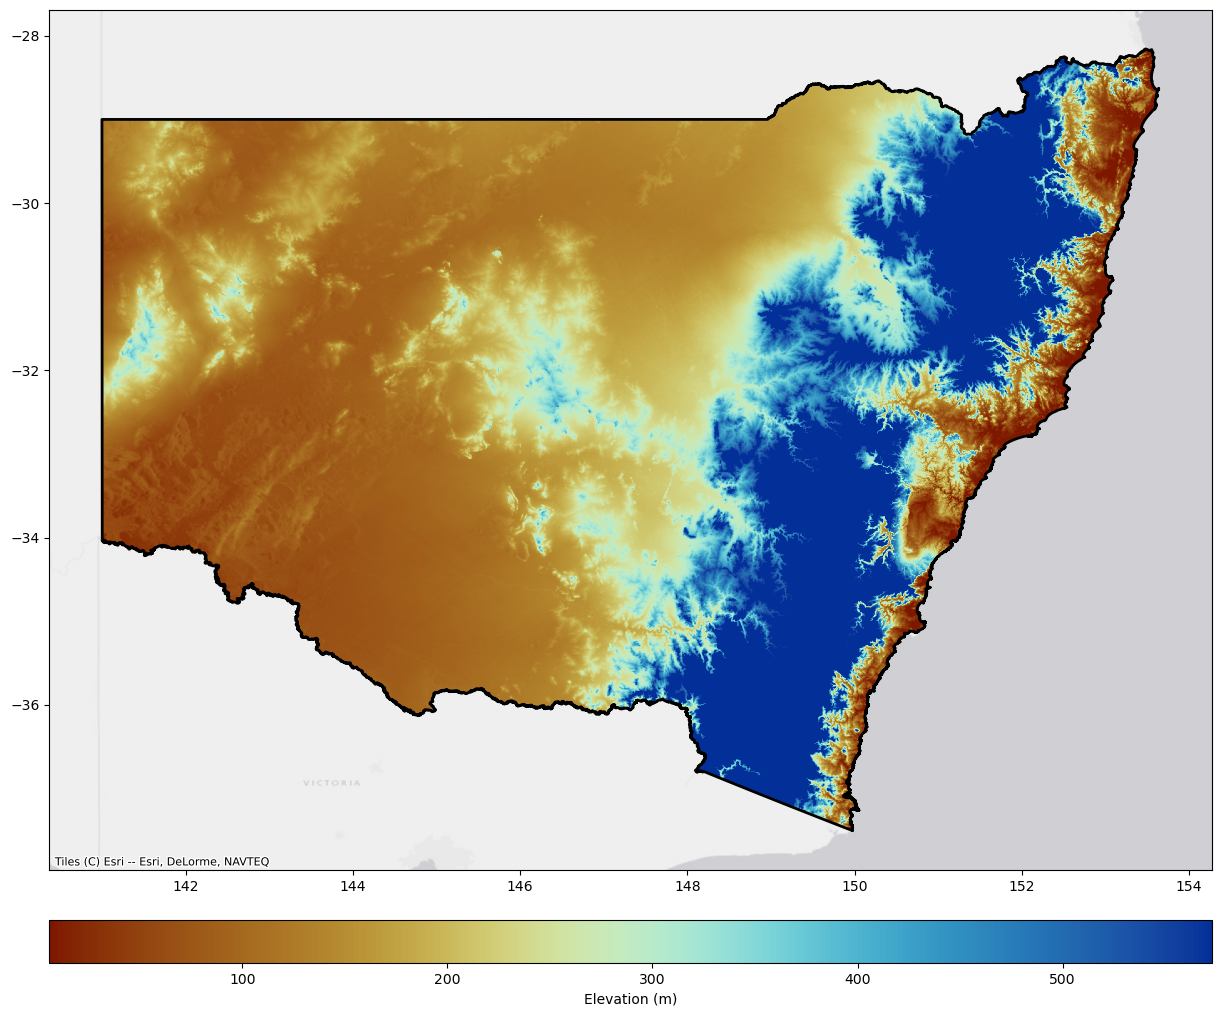

In [15]:
elevation_file = './Datasets/Elevation/Gravmap2019-grid-dem_geoid.tif'

raster = rxr.open_rasterio(elevation_file, masked=True).squeeze()

raster_array = raster.values
v_mean = np.nanmean(raster_array)
v_std = np.nanstd(raster_array)

fig, ax = plt.subplots(figsize=(15, 15))
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
cb = ax.imshow(raster_array, cmap=cmc.roma, extent=extent, vmin=v_mean-v_std, vmax=v_mean+v_std)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Elevation (m)', cax=cax)
plt.show()

### Extract the Coordinates of Mineral Occurrences

In [16]:
# export the coordinates to a CSV file
deposit_coords_file = './Datasets/Outputs/training_data_deposit_coords.csv'

if os.path.isfile(deposit_coords_file):
    print('The coordinates of deposits already exist.')
    deposit_coords = pd.read_csv(deposit_coords_file, index_col=False)
    deposit_num = int(deposit_coords.shape[0])
    deposit_x = pd.Series.tolist(deposit_coords['X'])
    deposit_y = pd.Series.tolist(deposit_coords['Y'])
else:
    deposit_x = min_occ.geometry.x
    deposit_y = min_occ.geometry.y
    deposit_num = min_occ.shape[0]
    deposit_coords = pd.DataFrame(deposit_x, columns=['X'])
    deposit_coords['Y'] = deposit_y
    
    size_code = pd.Series.tolist(min_occ['SIZE_CODE'])
    sample_weight = []
    for i in range(len(size_code)):
        if size_code[i] == 'VLG':
            sample_weight.append(0.5)
        elif size_code[i] == 'LGE':
            sample_weight.append(0.4)
        elif size_code[i] == 'MED':
            sample_weight.append(0.3)
        elif size_code[i] == 'SML':
            sample_weight.append(0.2)
        elif size_code[i] == 'OCC':
            sample_weight.append(0.1)
        
    deposit_coords['label'] = 1
    deposit_coords['sample_weight'] = sample_weight
    deposit_coords.to_csv(deposit_coords_file, index=False)
    print(f'The coordinates of deposits have been saved to {deposit_coords_file}.')

The coordinates of deposits already exist.


### Prepare the Training Data File

#### Vector Data Layers

##### Polylines

In [17]:
line_files = intrusion_bndy_files + metamorphic_bndy_files + bndy_files
line_files.append(metamorphic_iso_file)
line_files.append(vs_cluster_file)

deposit_lines_file = f'./Datasets/Outputs/training_data_deposit_lines.csv'

if os.path.isfile(deposit_lines_file):
    print('The lines dataset (deposits) already exists.')
    deposit_lines_data = pd.read_csv(deposit_lines_file, index_col=False)
else:
    deposit_lines_data = get_dist_line(deposit_x, deposit_y, line_files, distance_type='geodesic')
    deposit_lines_data.to_csv(deposit_lines_file, index=False)
    print(f'The lines dataset (deposits) has been saved to {deposit_lines_file}.')

The lines dataset (deposits) already exists.


##### Polygons

In [18]:
deposit_cat_file = f'./Datasets/Outputs/training_data_deposit_categorical.csv'

if os.path.isfile(deposit_cat_file):
    print('The categorical dataset (deposits) already exists.')
    deposit_cat_data = pd.read_csv(deposit_cat_file, index_col=False)
else:
    deposit_meta_fac = get_cat_data(deposit_x, deposit_y, meta_fac_files, field='MetFacies')
    deposit_intrusions = get_cat_data(deposit_x, deposit_y, intrusions_file, field='Dominant_L')
    deposit_rock_units = get_cat_data(deposit_x, deposit_y, rock_units_file, field='Dominant_L')
    deposit_cat_data = pd.concat([deposit_meta_fac, deposit_intrusions, deposit_rock_units], axis=1)
    deposit_cat_data.to_csv(deposit_cat_file, index=False)
    print(f'The categorical dataset (deposits) has been saved to {deposit_cat_file}.')

The categorical dataset (deposits) already exists.


#### Grids

In [19]:
grid_files = magnetic_files + gravity_files + radiometric_files + remote_sensing_files

deposit_grid_file = './Datasets/Outputs/training_data_deposit_grids.csv'

if os.path.isfile(deposit_grid_file):
    print('The grid dataset (deposits) already exists.')
    deposit_grid_data = pd.read_csv(deposit_grid_file, index_col=False)
else:
    deposit_grid_stat_data = get_grid_stat_features(deposit_x, deposit_y, grid_files, buffer_shape='square', buffer_size=10)
    deposit_grid_tex_data = get_grid_tex_features(deposit_x, deposit_y, grid_files, buffer_size=10)
    deposit_elev_stat_data = get_grid_grad_stat_features(deposit_x, deposit_y, elevation_file, buffer_shape='square', buffer_size=10)
    deposit_grid_data = pd.concat([deposit_grid_stat_data, deposit_grid_tex_data, deposit_elev_stat_data], axis=1)
    deposit_grid_data.to_csv(deposit_grid_file, index=False)
    print(f'The grid dataset (deposits) has been saved to {deposit_grid_file}.')

The grid dataset (deposits) already exists.


#### Create the Training Data File of Mineral Occurrences

In [20]:
# concatenate all the features generated using the coordinates of the mineral occurrences (positive samples)
deposit_training_data_file = f'./Datasets/Outputs/training_data_deposit.csv'

if os.path.isfile(deposit_training_data_file):
    print('The training data file (deposits) already exists.')
    deposit_training_data = pd.read_csv(deposit_training_data_file, index_col=False)    
    deposit_training_data_columns = deposit_training_data.columns.tolist()
    deposit_num_data_columns = []
    deposit_cat_data_columns = []

    for column in deposit_training_data_columns:
        if column.startswith('Intrusions_') or column.startswith('MetamorphicFacies') or column.startswith('RockUnits'):
            deposit_cat_data_columns.append(column)
        else:
            deposit_num_data_columns.append(column)
    
    deposit_num_data_columns = [e for e in deposit_num_data_columns if e not in ('label', 'sample_weight')]
    deposit_num_data = deposit_training_data[deposit_num_data_columns]
    deposit_cat_data = deposit_training_data[deposit_cat_data_columns]
else:
    deposit_training_data = pd.concat([
        deposit_coords,
        deposit_grid_data,
        deposit_lines_data,
        deposit_cat_data],
        axis=1
    )
    
    # remove the samples with missing values
    deposit_training_data = deposit_training_data.dropna()

    # separate numerical and categorical features
    deposit_num_data = deposit_training_data[deposit_training_data.columns[4:deposit_training_data.shape[1]-deposit_cat_data.shape[1]]]
    deposit_cat_data = deposit_training_data[deposit_training_data.columns[deposit_training_data.shape[1]-deposit_cat_data.shape[1]:deposit_training_data.shape[1]]]
    
    deposit_cat_data_columns = deposit_cat_data.columns.to_list()
    deposit_features = pd.concat([deposit_num_data, deposit_cat_data], axis=1).reset_index(drop=True)
    deposit_labels = deposit_training_data[deposit_training_data.columns[2]].reset_index(drop=True)
    deposit_weights = deposit_training_data[deposit_training_data.columns[3]].reset_index(drop=True)
    deposit_training_data = pd.concat([deposit_labels, deposit_weights, deposit_features], axis=1).reset_index(drop=True)
    deposit_training_data.to_csv(deposit_training_data_file, index=False)
    
    print(f'The training data file (deposits) has been saved to {deposit_training_data_file}.')

The training data file (deposits) already exists.


### Random (Unlabelled) Samples

The coordinates of unlabelled samples already exist.


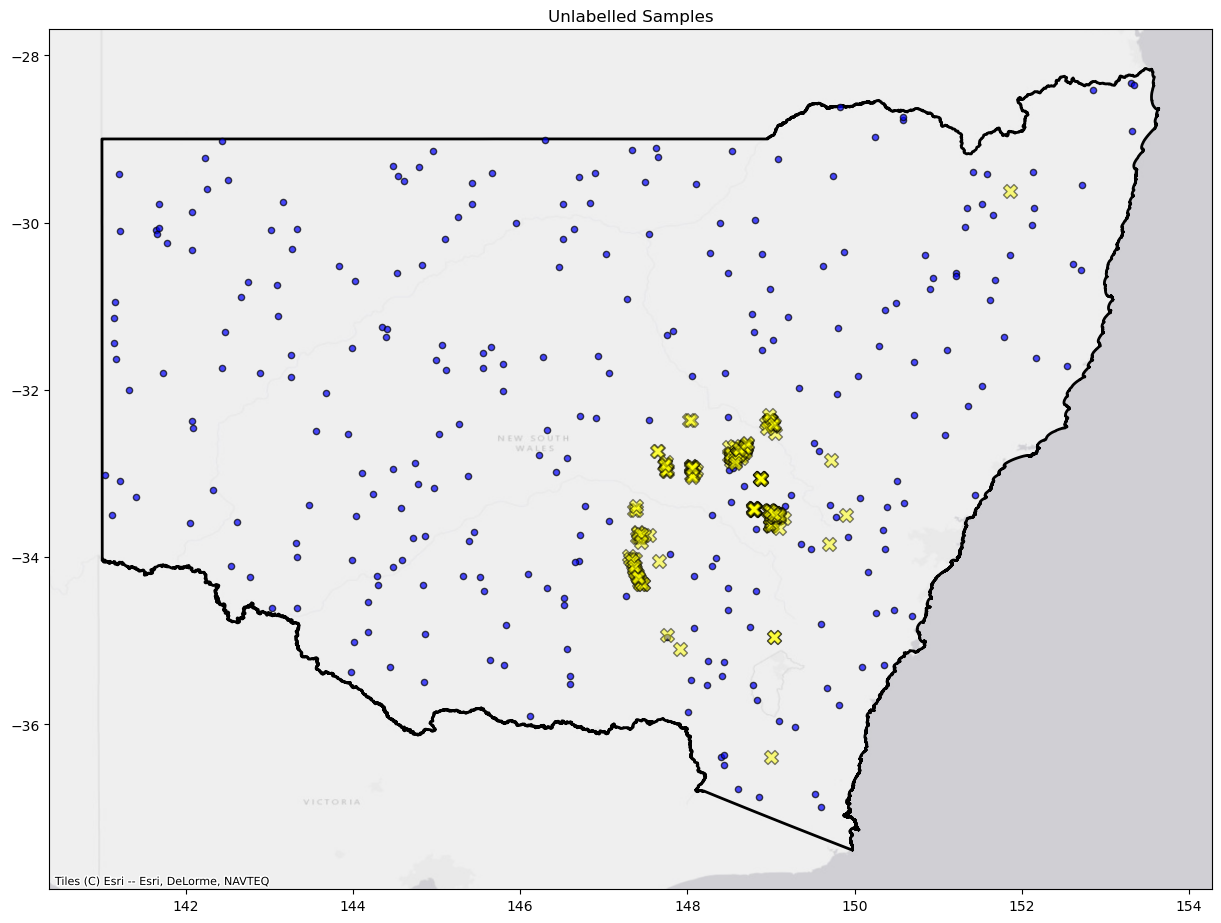

In [21]:
# generate and extract the coordinates of a number of random samples within the desired polygon
def get_unlab_samples(polygon, num_features):
    bounds = polygon.bounds
    
    rand_x = np.random.uniform(low=extent[0], high=extent[1], size=deposit_training_data.shape[0]*2)
    rand_y = np.random.uniform(low=extent[2], high=extent[3], size=deposit_training_data.shape[0]*2)
    
    unlab_x = []
    unlab_y = []

    for x, y in zip(rand_x, rand_y):
        if len(unlab_x) == deposit_training_data.shape[0]:
            break
        p = Point((x, y))
        if p.within(polygon.geometry[0]):
            unlab_x.append(x)
            unlab_y.append(y)
    
    return unlab_x, unlab_y

num_features = deposit_training_data.shape[1] - 1
# export the coordinates of the random samples to a CSV file
unlab_coords_file = './Datasets/Outputs/training_data_unlab_coords.csv'

if os.path.isfile(unlab_coords_file):
    print('The coordinates of unlabelled samples already exist.')
    unlab_coords = pd.read_csv(unlab_coords_file, index_col=False)
    unlab_x = pd.Series.tolist(unlab_coords['X'])
    unlab_y = pd.Series.tolist(unlab_coords['Y'])
else:
    unlab_x, unlab_y = get_unlab_samples(nsw_bndy, num_features)
    unlab_coords = pd.DataFrame(unlab_x, columns=['X'])
    unlab_coords['Y'] = unlab_y
    unlab_label = [0]*len(unlab_x)
    unlab_coords['label'] = unlab_label
    unlab_coords['sample_weight'] = 0.5
    unlab_coords.to_csv(unlab_coords_file, index=False)
    print(f'The coordinates of unlabelled samples have been saved to {unlab_coords_file}.')

# plot unlabelled samples
fig, ax = plt.subplots(figsize=(15, 15))
nsw_bndy.plot(ax=ax, edgecolor='black', color='none', linewidth=2)
# frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=2)
ax.scatter(unlab_x, unlab_y, color='blue', edgecolors='black', s=20, alpha=0.7)
min_occ.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title('Unlabelled Samples')
plt.show()

#### Create the Training Data File of Random Samples

In [22]:
unlab_lines_file = './Datasets/Outputs/training_data_unlab_lines.csv'

if os.path.isfile(unlab_lines_file):
    print('The lines dataset (unlabelled samples) already exists.')
    unlab_lines_data = pd.read_csv(unlab_lines_file, index_col=False)
else:
    unlab_lines_data = get_dist_line(unlab_x, unlab_y, line_files, distance_type='geodesic')
    unlab_lines_data = unlab_lines_data[unlab_lines_data.columns.intersection(deposit_lines_data.columns)]
    unlab_lines_data.to_csv(unlab_lines_file, index=False)
    print(f'The lines dataset (unlabelled samples) has been saved to {unlab_lines_file}.')

unlab_cat_file = './Datasets/Outputs/training_data_unlab_categorical.csv'

if os.path.isfile(unlab_cat_file):
    print('The categorical dataset (unlabelled samples) already exists.')
    unlab_cat_data = pd.read_csv(unlab_cat_file, index_col=False)
else:
    unlab_meta_fac = get_cat_data(unlab_x, unlab_y, meta_fac_files, field='MetFacies')
    unlab_intrusions = get_cat_data(unlab_x, unlab_y, intrusions_file, field='Dominant_L')
    unlab_rock_units = get_cat_data(unlab_x, unlab_y, rock_units_file, field='Dominant_L')
    unlab_cat_data = pd.concat([unlab_meta_fac, unlab_intrusions, unlab_rock_units], axis=1)
    unlab_cat_data = unlab_cat_data[unlab_cat_data.columns.intersection(deposit_cat_data.columns)]
    unlab_cat_data.to_csv(unlab_cat_file, index=False)
    print(f'The categorical dataset (unlabelled samples) has been saved to {unlab_cat_file}.')

unlab_grid_file = './Datasets/Outputs/training_data_unlab_grids.csv'

if os.path.isfile(unlab_grid_file):
    print('The grid dataset (unlabelled samples) already exists.')
    unlab_grid_data = pd.read_csv(unlab_grid_file, index_col=False)
else:
    unlab_grid_stat_data = get_grid_stat_features(unlab_x, unlab_y, grid_files, buffer_shape='square', buffer_size=10)
    unlab_grid_tex_data = get_grid_tex_features(unlab_x, unlab_y, grid_files, buffer_size=10)
    unlab_elev_stat_data = get_grid_grad_stat_features(unlab_x, unlab_y, elevation_file, buffer_shape='square', buffer_size=10)
    unlab_grid_data = pd.concat([unlab_grid_stat_data, unlab_grid_tex_data, unlab_elev_stat_data], axis=1)
    unlab_grid_data = unlab_grid_data[unlab_grid_data.columns.intersection(deposit_grid_data.columns)]
    unlab_grid_data.to_csv(unlab_grid_file, index=False)
    print(f'The grid dataset (unlabelled samples) has been saved to {unlab_grid_file}.')

The lines dataset (unlabelled samples) already exists.
The categorical dataset (unlabelled samples) already exists.
The grid dataset (unlabelled samples) already exists.


In [23]:
# concatenate all the features generated in the previous cell
unlab_training_data_file = './Datasets/Outputs/training_data_unlab.csv'

if os.path.isfile(unlab_training_data_file):
    print('The training data file (unlabelled samples) already exists.')
    unlab_training_data = pd.read_csv(unlab_training_data_file, index_col=False)
else:
    unlab_training_data = pd.concat([
        unlab_coords,
        unlab_grid_data,
        unlab_lines_data,
        unlab_cat_data],
        axis=1
    )
    
    # remove missing values
    unlab_training_data = unlab_training_data.dropna()
    unlab_training_data = unlab_training_data[unlab_training_data.columns.intersection(deposit_training_data.columns)]
    unlab_training_data.to_csv(unlab_training_data_file, index=False)
    
    print(f'The training data file (unlabelled samples) has been saved to {unlab_training_data_file}.')

Xy_train_original_file = './Datasets/Outputs/Xy_train_original.csv'

if os.path.isfile(Xy_train_original_file):
    Xy_train_original = pd.read_csv(Xy_train_original_file, index_col=False)
    print('Features file already exists!')
    
    with open('./Datasets/Outputs/st_scaler.pkl', 'rb') as f:
        st_scaler = pickle.load(f)
        
    with open('./Datasets/Outputs/encoder.pkl', 'rb') as f:
        enc = pickle.load(f)
else:
    deposit_labels = deposit_training_data['label']
    unlab_labels = unlab_training_data['label']
    
    deposit_weights = deposit_training_data['sample_weight']
    unlab_weights = unlab_training_data['sample_weight']
    
    labels = pd.concat([deposit_labels, unlab_labels]).reset_index(drop=True)
    weights = pd.concat([deposit_weights, unlab_weights]).reset_index(drop=True)
    
    training_data_original = pd.concat([deposit_training_data, unlab_training_data]).reset_index(drop=True)
    
    # separate numerical and categorical features
    training_data_num = training_data_original[deposit_num_data.columns]
    training_data_cat = training_data_original[deposit_cat_data.columns]

    # drop highly correlated features
    # create a correlation matrix
    corr_matrix = training_data_num.corr(method='spearman').abs()
    corr_matrix.to_csv('./Datasets/Outputs/corr.csv', index=True)
    # select the upper triangle of the correlation matrix
    corr_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # find features with the correlation greater than 0.7
    corr_drop = [column for column in corr_upper.columns if any(corr_upper[column] > 0.7)]
    # print('List of the features removed due to high correlation with other features:', corr_drop)
    # drop features
    training_data_num_purged = training_data_num.drop(corr_drop, axis=1)
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(training_data_cat)
    training_data_cat_encoded = enc.transform(training_data_cat).toarray()
    
    try:
        training_data_cat_columns = enc.get_feature_names(training_data_cat.columns).tolist()
    except:
        training_data_cat_columns = enc.get_feature_names_out(training_data_cat.columns).tolist()
    
    training_data_cat_encoded = pd.DataFrame(training_data_cat_encoded, columns=training_data_cat_columns)
    
    features_labels_encoded = pd.concat([training_data_num_purged, training_data_cat_encoded, weights, labels], axis=1).reset_index(drop=True)
    features_labels_list = features_labels_encoded.columns.tolist()
    features_list = features_labels_list.copy()
    features_list = [e for e in features_list if e not in ('label', 'sample_weight')]

    deposit_data = features_labels_encoded[features_labels_encoded['label']==1]
    unlab_data = features_labels_encoded[features_labels_encoded['label']==0]

    deposit_features = deposit_data[deposit_data.columns[:-1]]
    unlab_features = unlab_data[unlab_data.columns[:-1]]

    deposit_labels = deposit_data[deposit_data.columns[-1]]
    unlab_labels = unlab_data[unlab_data.columns[-1]]

#     deposit_weights = deposit_data[deposit_data.columns[-2]]
#     unlab_weights = unlab_data[unlab_data.columns[-2]]
    
#     deposit_labels_weights = np.vstack((deposit_labels, deposit_weights))
    
    # train test
    # split positive samples into training and test datasets
    X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(deposit_features, deposit_labels, train_size=0.75, random_state=42)
    X_train = np.vstack((X_pos_train, unlab_features))
    y_train = np.vstack((y_pos_train.values.reshape(-1, 1), unlab_labels.values.reshape(-1, 1)))
    
    Xy_train_original = np.hstack((X_train, y_train))
    Xy_train_original = pd.DataFrame(Xy_train_original, columns=features_labels_list)
    Xy_train_original.to_csv('./Datasets/Outputs/Xy_train_original.csv', index=False)
    
    X_pos_test_df = pd.DataFrame(X_pos_test, columns=features_list).reset_index(drop=True)
    y_pos_test_df = pd.DataFrame(y_pos_test, columns=['label']).reset_index(drop=True)
    weights_pos_df = pd.DataFrame(X_pos_test, columns=['sample_weight']).reset_index(drop=True)
    
    X_train_num = Xy_train_original[training_data_num_purged.columns]
    
    st_scaler = StandardScaler()
    X_train_num = st_scaler.fit_transform(X_train_num)
    X_train_num = pd.DataFrame(X_train_num, columns=training_data_num_purged.columns)
    
    X_pos_test_num = X_pos_test_df[training_data_num_purged.columns]
    X_pos_test_num = st_scaler.transform(X_pos_test_num)
    X_pos_test_num = pd.DataFrame(X_pos_test_num, columns=training_data_num_purged.columns)
    
    Xy_train = pd.concat([X_train_num, Xy_train_original[training_data_cat_columns], Xy_train_original['sample_weight'], Xy_train_original['label']], axis=1).reset_index(drop=True)
    Xy_pos_test = pd.concat([X_pos_test_num, X_pos_test_df[training_data_cat_columns], weights_pos_df, y_pos_test_df], axis=1).reset_index(drop=True)
    
    Xy_train.to_csv('./Datasets/Outputs/Xy_train.csv', index=False)
    Xy_pos_test.to_csv('./Datasets/Outputs/Xy_pos_test.csv', index=False)
    
    # save the standard scaler model
    with open('./Datasets/Outputs/st_scaler.pkl', 'wb') as f:
        pickle.dump(st_scaler, f)
        
    # save the encoder model
    with open('./Datasets/Outputs/encoder.pkl', 'wb') as f:
        pickle.dump(enc, f)

The training data file (unlabelled samples) already exists.
Features file already exists!


In [24]:
def analyze_correlations(file_path, threshold=0.7):
    # Read the correlation matrix
    corr_matrix = pd.read_csv(file_path, index_col=0)
    
    # Dictionary to store correlations
    correlations = {}
    
    for column in corr_matrix.columns:
        positive_corr = []
        negative_corr = []
        feature = corr_matrix[column]
        
        for i in range(feature.shape[0]):
            if abs(feature[i]) >= threshold and feature.index[i] != column:
                if feature[i] > 0:
                    positive_corr.append((feature.index[i], feature[i]))
                else:
                    negative_corr.append((feature.index[i], feature[i]))
        
        if positive_corr or negative_corr:
            correlations[column] = {
                'positive': sorted(positive_corr, key=lambda x: x[1], reverse=True),
                'negative': sorted(negative_corr, key=lambda x: x[1])
            }
    
    return correlations

def generate_report(correlations, threshold):
    print(f"Correlation Analysis Report (Threshold: {threshold})")
    print("=" * 50)
    
    for feature, corr in correlations.items():
        print(f"\nFeature: {feature}")
        print("-" * 30)
        
        if corr['positive']:
            print("Positive Correlations:")
            for c, value in corr['positive']:
                print(f"  {c}: {value:.3f}")
        
        if corr['negative']:
            print("Negative Correlations:")
            for c, value in corr['negative']:
                print(f"  {c}: {value:.3f}")
    
    print("\nTotal features with strong correlations:", len(correlations))

# Main execution
file_path = './Datasets/Outputs/corr.csv'
threshold = 0.7

correlations = analyze_correlations(file_path, threshold)
generate_report(correlations, threshold)

Correlation Analysis Report (Threshold: 0.7)

Feature: Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean
------------------------------
Positive Correlations:
  Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019_mean: 0.949
  Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019_mean: 0.869
  Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019_mean: 0.812
  Magmap2019-grid-tmi_rtp_05vd-AWAGS_MAG_2019_mean: 0.720

Feature: Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_std
------------------------------
Positive Correlations:
  Magmap2019-grid-tmi_rtp_enhancement-Bzz-AWAGS_MAG_2019_std: 0.990
  Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019_std: 0.986
  Magmap2019-grid-tmi_rtp_upcon-UC0m500mRes-AWAGS_MAG_2019_std: 0.972
  Magmap2019-grid-tmi_rtp_05vd-AWAGS_MAG_2019_std: 0.966
  Magmap2019-grid-tmi_rtp_as-AWAGS_MAG_2019_std: 0.958
  Magmap2019-grid-tmi_rtp_as-AWAGS_MAG_2019_mean: 0.958
  Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_min: 0.940
  Magmap2019-grid-tmi_rtp_1vd-AWAGS_MAG_2019_max: 0.937
  Magmap2019-gr

### Positive and Unlabelled Bagging

In [25]:
model_pub_file = './Datasets/Outputs/model_pub.pkl'

if os.path.isfile(model_pub_file):
    print('A PUB model file exists. Attempting to load...')
    try:
        with open(model_pub_file, 'rb') as f:
            model_pub = pickle.load(f)
        print('Model loaded successfully.')
    except (ModuleNotFoundError, ImportError) as e:
        print(f"Error loading the model: {e}")
        print("This may be due to a version mismatch. Proceeding to train a new model.")
        model_pub = None
else:
    print('No existing model found. Proceeding to train a new model.')
    model_pub = None

if model_pub is None:
    # Random Forest model structure
    rf_pub = RandomForestClassifier(n_jobs=-1, random_state=42)
    pub = BaggingPuClassifier(rf_pub, n_jobs=-1, random_state=42)

    n_fold = 10

    Xy_train_file = f'./Datasets/Outputs/Xy_train.csv'
    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    features = Xy_train[Xy_train.columns[:-1]]
    labels = Xy_train[Xy_train.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=42)
    
    Xy_pub_train = np.hstack((X_train, y_train.values.reshape(-1, 1)))
    Xy_pub_train = pd.DataFrame(Xy_pub_train, columns=Xy_train.columns)
    Xy_pub_train.to_csv('./Datasets/Outputs/Xy_pub_train.csv', index=False)
    
    Xy_pub_test = np.hstack((X_test, y_test.values.reshape(-1, 1)))
    Xy_pub_test = pd.DataFrame(Xy_pub_test, columns=Xy_train.columns)
    Xy_pub_test.to_csv('./Datasets/Outputs/Xy_pub_test.csv', index=False)

    weights_train = X_train[X_train.columns[-1]]
    X_train = X_train[X_train.columns[:-1]]
    weights_test = X_test[X_test.columns[-1]]
    X_test = X_test[X_test.columns[:-1]]

    search_space = {
    'base_estimator__bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
    'base_estimator__max_depth': Integer(5, 20), # values of max_depth are integers
    'base_estimator__max_features': Categorical([None, 'sqrt','log2']), 
    'base_estimator__min_samples_leaf': Integer(2, 20),
    'base_estimator__min_samples_split': Integer(2, 30),
    'base_estimator__n_estimators': Integer(10, 200),
    'max_samples': Integer(int(0.5*(len(y_train)-sum(y_train))), int(0.9*(len(y_train)-sum(y_train))))
    }

    pub_bayes_search = BayesSearchCV(pub,
                                     search_space,
                                     n_iter=100, # specify how many iterations
                                     scoring='f1',
                                     n_jobs=4,
                                     cv=n_fold,
                                     verbose=1,
                                     random_state=42)
    pub_bayes_search.fit(X_train, y_train, sample_weight=weights_train)
    
    # Extract the optimization results
    optimization_results = pub_bayes_search.cv_results_['mean_test_score']
    
    model_pub = pub_bayes_search.best_estimator_
    model_pub_acc = pub_bayes_search.best_score_    
    print('The highest accuracy during cross validation:', model_pub_acc)
    
    # save the model
    with open(model_pub_file, 'wb') as f:
        pickle.dump(model_pub, f)
    
    # Plot the Bayesian optimization progress
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(optimization_results) + 1), optimization_results, marker='o', color='black', markerfacecolor='red')
    plt.xlim(0, 101)
    plt.xlabel('Bayesian Optimization Iteration')
    plt.ylabel('Mean Test Precision')
    plt.title('Bayesian Optimization Progress')
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.savefig('./Datasets/Outputs/bayesian_optimization_pub_progress.png')
    plt.show()

A PUB model file exists. Attempting to load...
Model loaded successfully.


In [26]:
print(model_pub)

Xy_pub_test_file = f'./Datasets/Outputs/Xy_pub_test.csv'
Xy_pub_test = pd.read_csv(Xy_pub_test_file, index_col=False)

features = Xy_pub_test[Xy_pub_test.columns[:-2]]
labels = Xy_pub_test[Xy_pub_test.columns[-1]]
weights = Xy_pub_test[Xy_pub_test.columns[-2]]

X_pred = model_pub.predict(features)

# assuming that all zeros in labels are true negative samples
cMatrix = confusion_matrix(labels, X_pred)
X_pred_acc = accuracy_score(labels, X_pred, sample_weight=weights)
X_pred_pre = precision_score(labels, X_pred, sample_weight=weights)
X_pred_rec = recall_score(labels, X_pred, sample_weight=weights)
X_pred_f1 = f1_score(labels, X_pred, sample_weight=weights)

print('Confusion matrix:\n', cMatrix)
print('Accuracy:', X_pred_acc)
print('Precision:', X_pred_pre)
print('Recall:', X_pred_rec)
print('F1-Score:', X_pred_f1)

BaggingPuClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                          max_depth=14,
                                                          max_features='log2',
                                                          min_samples_leaf=2,
                                                          min_samples_split=6,
                                                          n_estimators=170,
                                                          n_jobs=-1,
                                                          random_state=42),
                    max_samples=187, n_jobs=-1, random_state=42)
Confusion matrix:
 [[64  0]
 [ 6 50]]
Accuracy: 0.9770408163265305
Precision: 1.0
Recall: 0.875
F1-Score: 0.9333333333333333


In [27]:
Xy_pos_test = pd.read_csv('./Datasets/Outputs/Xy_pos_test.csv', index_col=False)
X_pos_test = Xy_pos_test[Xy_pos_test.columns[:-2]]
y_pos_test = Xy_pos_test[Xy_pos_test.columns[-1]]
weights_test = Xy_pos_test[Xy_pos_test.columns[-2]]
X_pos_pred = model_pub.predict(X_pos_test)
X_pos_pred_acc = accuracy_score(y_pos_test, X_pos_pred, sample_weight=weights_test)
print('Accuracy:', X_pos_pred_acc)

Accuracy: 0.9134615384615384


In [28]:
Xy_train = pd.read_csv('./Datasets/Outputs/Xy_train.csv', index_col=False)
Xy_train_features = Xy_train[Xy_train.columns[:-2]]
Xy_train_labels = Xy_train[Xy_train.columns[-1]]
Xy_train_weights = Xy_train[Xy_train.columns[-2]]
Xy_train_labels_new = model_pub.predict(Xy_train_features)

Xy_train_labels_new_acc = accuracy_score(Xy_train_labels, Xy_train_labels_new, sample_weight=Xy_train_weights)
Xy_train_labels_new_pre = precision_score(Xy_train_labels, Xy_train_labels_new, sample_weight=Xy_train_weights)
Xy_train_labels_new_rec = recall_score(Xy_train_labels, Xy_train_labels_new, sample_weight=Xy_train_weights)
Xy_train_labels_new_f1 = f1_score(Xy_train_labels, Xy_train_labels_new, sample_weight=Xy_train_weights)

# assuming that all zeros in Xy_train_labels are true negative samples
print('Accuracy:', Xy_train_labels_new_acc)
print('Precision:', Xy_train_labels_new_pre)
print('Recall:', Xy_train_labels_new_rec)
print('F1-Score:', Xy_train_labels_new_f1)

Xy_train_new_file = './Datasets/Outputs/Xy_train_new.csv'

if os.path.isfile(Xy_train_new_file):
    Xy_train_new = pd.read_csv(Xy_train_new_file, index_col=False)
else:
    mask = Xy_train_labels == 1
    Xy_train_labels_new[mask] = 1
    Xy_train['label'] = Xy_train_labels_new
    Xy_train.to_csv(Xy_train_new_file, index=False)

Accuracy: 0.994620442319187
Precision: 1.0
Recall: 0.9712460063897763
F1-Score: 0.9854132901134521


### Create the Predictive Model

In [29]:
model_rf_file = './Datasets/Outputs/model_rf.pkl'

if os.path.isfile(model_rf_file):
    print('A model file exists. Attempting to load...')
    try:
        with open(model_rf_file, 'rb') as f:
            model_rf = pickle.load(f)
        print('Model loaded successfully.')
    except (ModuleNotFoundError, ImportError) as e:
        print(f"Error loading the model: {e}")
        print("This may be due to a version mismatch. Proceeding to train a new model.")
        model_rf = None
else:
    print('No existing model found. Proceeding to train a new model.')
    model_rf = None

if model_rf is None:
    # Random Forest model structure
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)

    n_fold = 10

    Xy_train_file = f'./Datasets/Outputs/Xy_train_new.csv'
    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    features = Xy_train[Xy_train.columns[:-1]]
    labels = Xy_train[Xy_train.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=42)

    Xy_rf_train = np.hstack((X_train, y_train.values.reshape(-1, 1)))
    Xy_rf_train = pd.DataFrame(Xy_rf_train, columns=Xy_train.columns)
    Xy_rf_train.to_csv('./Datasets/Outputs/Xy_rf_train.csv', index=False)
    
    Xy_rf_test = np.hstack((X_test, y_test.values.reshape(-1, 1)))
    Xy_rf_test = pd.DataFrame(Xy_rf_test, columns=Xy_train.columns)
    Xy_rf_test.to_csv('./Datasets/Outputs/Xy_rf_test.csv', index=False)

    weights_train = X_train[X_train.columns[-1]]
    X_train = X_train[X_train.columns[:-1]]
    weights_test = X_test[X_test.columns[-1]]
    X_test = X_test[X_test.columns[:-1]]

    search_space = {
    'bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
    'max_depth': Integer(5, 20), # values of max_depth are integers
    'max_features': Categorical([None, 'sqrt','log2']), 
    'min_samples_leaf': Integer(2, 20),
    'min_samples_split': Integer(2, 30),
    'n_estimators': Integer(10, 200)
    }

    rf_bayes_search = BayesSearchCV(rf,
                                    search_space,
                                    n_iter=100, # specify how many iterations
                                    scoring='f1',
                                    n_jobs=4,
                                    cv=n_fold,
                                    verbose=1,
                                    random_state=42)
    rf_bayes_search.fit(X_train, y_train, sample_weight=weights_train)
    
    # Extract the optimization results
    optimization_results = rf_bayes_search.cv_results_['mean_test_score']
    
    model_rf = rf_bayes_search.best_estimator_
    model_rf_acc = rf_bayes_search.best_score_ 
    print('The highest accuracy during cross validation:', model_rf_acc)
    
    # save the model
    with open('./Datasets/Outputs/model_rf.pkl', 'wb') as f:
        pickle.dump(model_rf, f)
    
    importances = []
    estimators = model_rf.estimators_
    importances = [estimators[j].feature_importances_.reshape(-1, 1) for j in range(len(estimators))]
    importances = np.hstack(importances)

    # Plot the Bayesian optimization progress
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(optimization_results) + 1), optimization_results, marker='o', color='black', markerfacecolor='red')
    plt.xlim(0, 101)
    plt.xlabel('Bayesian Optimization Iteration')
    plt.ylabel('Mean Test Accuracy')
    plt.title('Bayesian Optimization Progress')
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.savefig('./Datasets/Outputs/bayesian_optimization_rf_progress.png')
    plt.show()
else:
    print("Using the loaded model. No new training performed.")
    print("To retrain the model, delete or rename the existing model file and run the script again.")

print("Script execution completed.")

A model file exists. Attempting to load...
Model loaded successfully.
Using the loaded model. No new training performed.
To retrain the model, delete or rename the existing model file and run the script again.
Script execution completed.


In [30]:
print(model_rf)

Xy_rf_test_file = f'./Datasets/Outputs/Xy_rf_test.csv'
Xy_rf_test = pd.read_csv(Xy_rf_test_file, index_col=False)

features = Xy_rf_test[Xy_rf_test.columns[:-2]]
labels = Xy_rf_test[Xy_rf_test.columns[-1]]
weights = Xy_rf_test[Xy_rf_test.columns[-2]]

X_pred = model_rf.predict(features)

cMatrix = confusion_matrix(labels, X_pred)
X_pred_acc = accuracy_score(labels, X_pred, sample_weight=weights)
X_pred_pre = precision_score(labels, X_pred, sample_weight=weights)
X_pred_rec = recall_score(labels, X_pred, sample_weight=weights)
X_pred_f1 = f1_score(labels, X_pred, sample_weight=weights)

print('Confusion matrix:\n', cMatrix)
print('Accuracy:', X_pred_acc)
print('Precision:', X_pred_pre)
print('Recall:', X_pred_rec)
print('F1-Score:', X_pred_f1)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       n_estimators=103, n_jobs=-1, random_state=42)
Confusion matrix:
 [[64  0]
 [ 6 50]]
Accuracy: 0.9770408163265305
Precision: 1.0
Recall: 0.875
F1-Score: 0.9333333333333333


In [31]:
Xy_pos_test = pd.read_csv('./Datasets/Outputs/Xy_pos_test.csv', index_col=False)
X_pos_test = Xy_pos_test[Xy_pos_test.columns[:-2]]
y_pos_test = Xy_pos_test[Xy_pos_test.columns[-1]]
weights_test = Xy_pos_test[Xy_pos_test.columns[-2]]
X_pos_pred = model_rf.predict(X_pos_test)
X_pos_pred_acc = accuracy_score(y_pos_test, X_pos_pred, sample_weight=weights_test)
print('Accuracy:', X_pos_pred_acc)

Accuracy: 0.894230769230769


#### ROC Plot

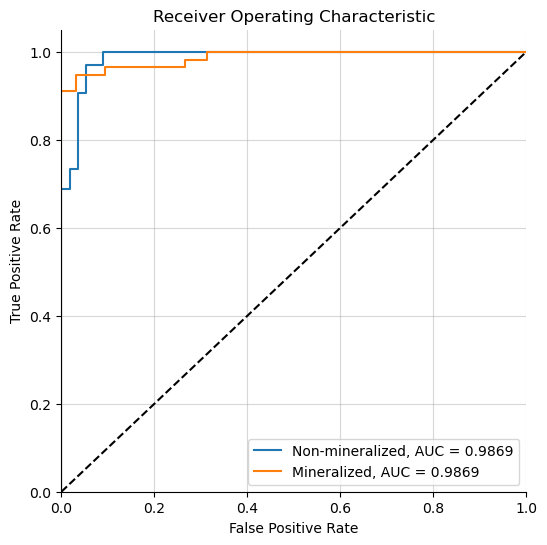

ROC AUC score: 0.9868861607142858


In [32]:
def roc_plot(y_test, z_test, n_classes, labels_name, average='macro'):
    fpr = {}
    tpr = {}
    roc_auc = {}

    y_test_dummies = pd.get_dummies(y_test).values
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], z_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{}, AUC = {}'.format(labels_name[i], '{0:.4f}'.format(roc_auc[i])))
    
    ax.legend(loc='best')
    ax.grid(alpha=0.5)
    sns.despine()
    plt.show()
    print('ROC AUC score:', roc_auc_score(y_test_dummies, z_test, average=average))

# predict for the test dataset
z_test = model_rf.predict_proba(features)

labels_name = ['Non-mineralized', 'Mineralized']
roc_plot(labels, z_test, 2, labels_name)

#### Feature Importance

In [33]:
features_importance_file = './Datasets/Outputs/features_importance.csv'

if os.path.isfile(features_importance_file):
    features_importance = pd.read_csv(features_importance_file, index_col=False).to_numpy().tolist()
else:
    output_features = Xy_train_original.columns.tolist()
    output_features = [e for e in output_features if e not in ('label', 'sample_weight')]
    
    importances_mean = importances.mean(axis=1)
    importances_var = importances.var(axis=1)

    features_importance = [(feature, round(importance, 5)) for feature, importance in zip(output_features, importances_mean)]
    features_importance = sorted(features_importance, key=lambda x:x[1], reverse=True)
    features_importance_df = pd.DataFrame(features_importance, columns=['Feature', 'Importance'])
    features_importance_df['Variance'] = importances_var
    features_importance_df.to_csv(features_importance_file, index=False)

Text(0, 0.5, 'Cumulative Importance')

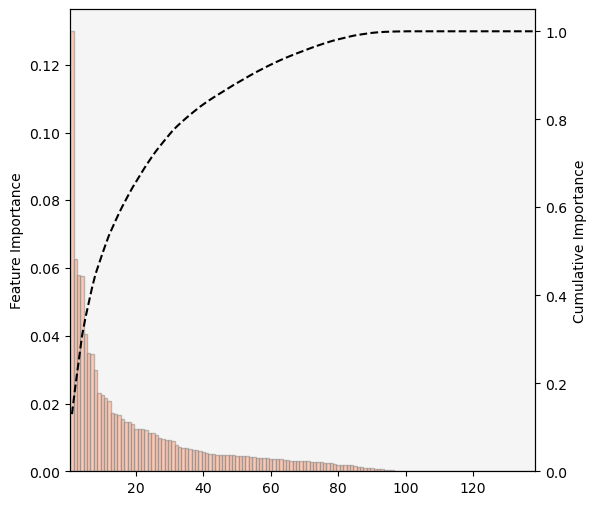

In [34]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in features_importance]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)

x_values = list(range(len(features_importance)))
x_values = [x+1 for x in x_values]

fig = plt.figure(figsize=(6, 6))
ax2 = fig.add_subplot(111)
ax1 = ax2.twinx()
ax2.set_facecolor('whitesmoke')

ax2.bar(x_values, sorted_importances, edgecolor='gray', facecolor='LightSalmon', width=1, alpha=0.5)
ax1.plot(x_values, cumulative_importances, 'k--')

plt.xticks(rotation=30)
plt.xlim(0.5, len(cumulative_importances)+0.5)

ax1.set_ylim(0, 1.05)

ax2.set_ylabel('Feature Importance')
ax1.set_ylabel('Cumulative Importance')

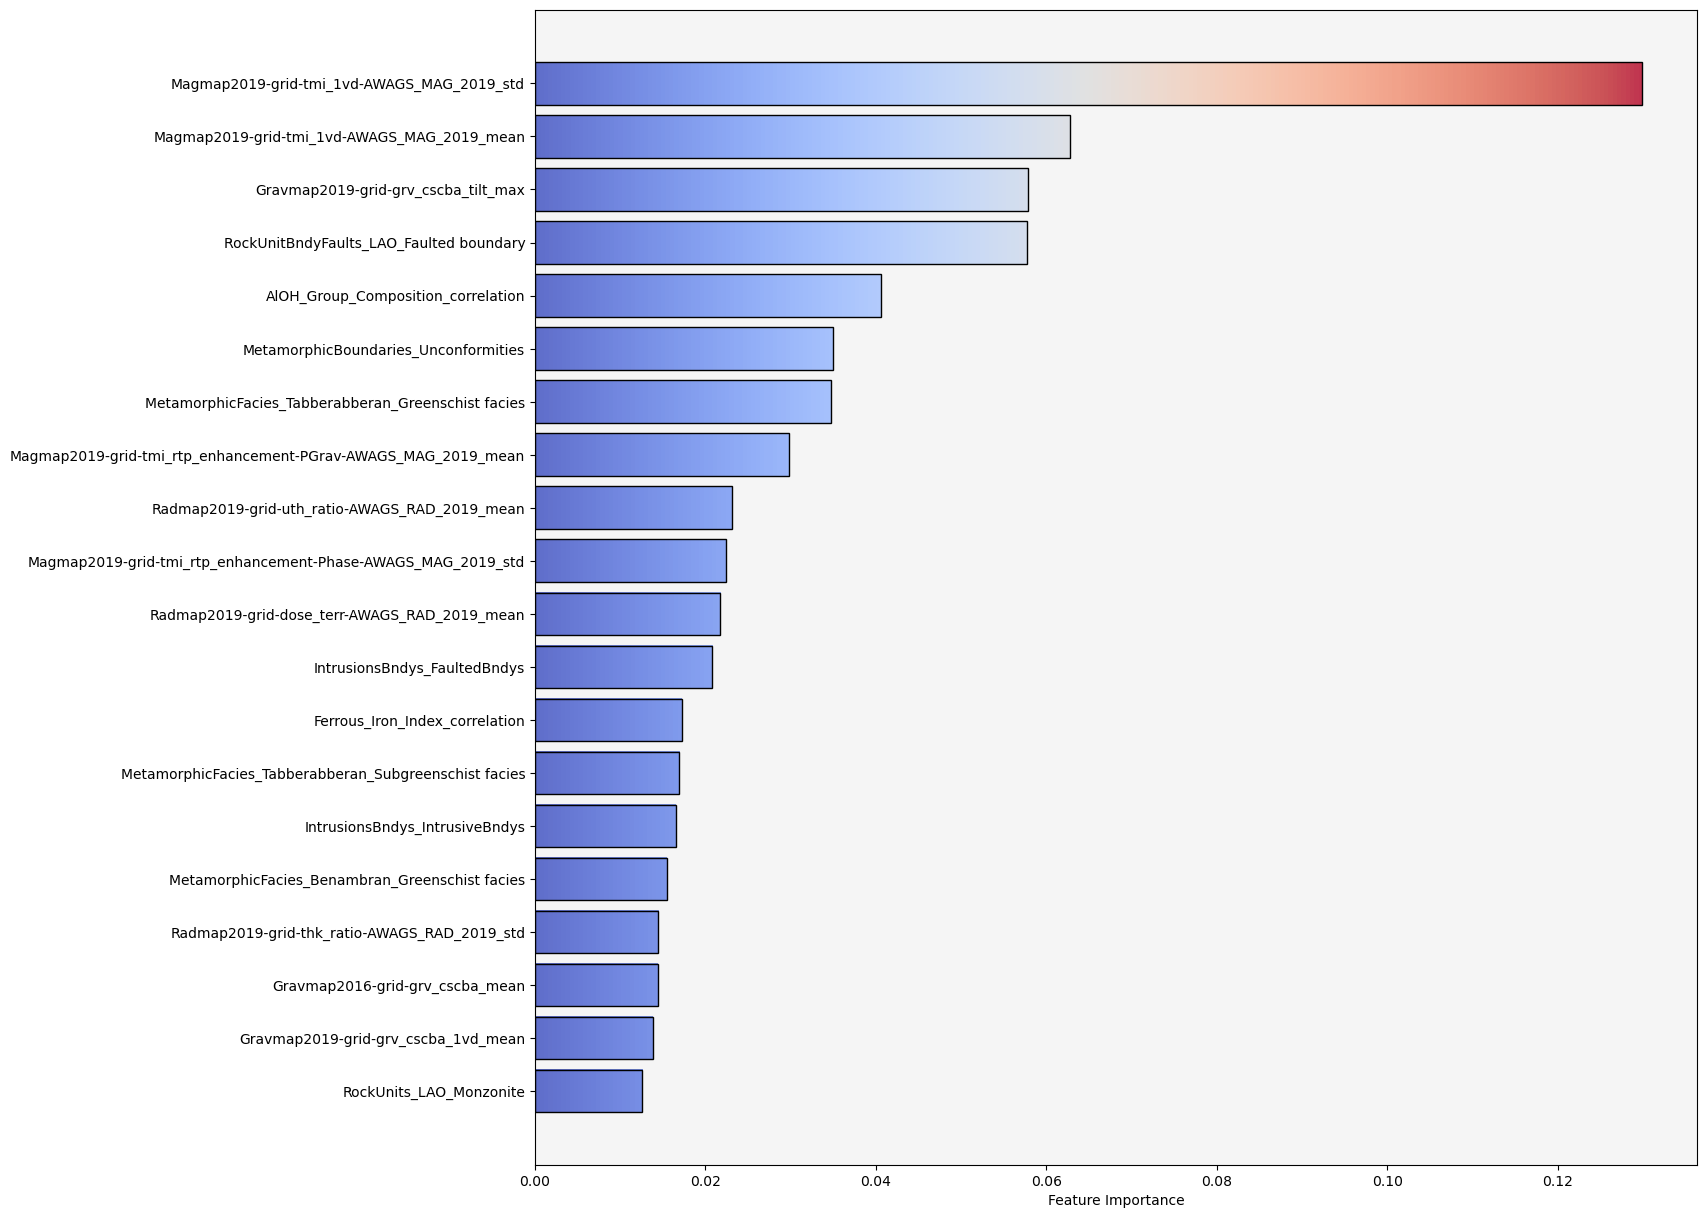

In [35]:
# print significant features above some threshold
features_importance_top = features_importance[:20]
features_importance_top.sort(key=lambda x:x[1])
ft_imps = [x[1] for x in features_importance_top]

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('whitesmoke')
bar = ax.barh(range(len(ft_imps)), ft_imps)

def gradientbars(bars, data):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        bar.set_edgecolor('black')
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        cmap = plt.get_cmap('coolwarm')
        grad = np.atleast_2d(np.linspace(0, 1*w/max(data), 256))
        ax.imshow(grad, extent=[x, x+w, y, y+h], aspect='auto', zorder=0, norm=mpl.colors.NoNorm(vmin=0, vmax=1), cmap=cmap, alpha=0.8)
        manual_labels = [x[0] for x in features_importance_top]
        ax.set_yticks(np.arange(0, len(data), 1).tolist())
        ax.set_yticklabels(manual_labels, minor=False)
    ax.axis(lim)
    ax.set_xlabel('Feature Importance')

gradientbars(bar, ft_imps)
plt.gca().yaxis.grid(False)
plt.show()

#### Histogram

In [36]:
Xy_train_new = pd.read_csv('./Datasets/Outputs/Xy_train_new.csv', index_col=False)
Xy_train_original = pd.read_csv('./Datasets/Outputs/Xy_train_original.csv', index_col=False)

@interact
def show_map(feature=Xy_train_new.columns):
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_facecolor('whitesmoke')
    ax2 = ax1.twiny()
    ax3 = ax2.twinx()
    
    # Calculate bin edges based on the entire dataset
    min_val = Xy_train_new[feature].min()
    max_val = Xy_train_new[feature].max()
    bin_edges = np.linspace(min_val, max_val, 26)  # 25 bins, 26 edges
    
    # Histogram for original data (transparent)
    ax1.hist(Xy_train_original[feature], bins=25, alpha=0.0)
    
    # Histograms for standardized data with black edges and consistent bin widths
    h1 = ax2.hist(Xy_train_new.loc[Xy_train_new['label']==0][feature], bins=bin_edges, 
                  color='LightSalmon', label='Negative', 
                  edgecolor='black', linewidth=1)
    h2 = ax2.hist(Xy_train_new.loc[Xy_train_new['label']==1][feature], bins=bin_edges, 
                  color='DarkSeaGreen', label='Positive', alpha=0.8, 
                  edgecolor='black', linewidth=1)
    
    kde_x = np.linspace(min_val, max_val, 100)
    
    kde1 = stats.gaussian_kde(Xy_train_new.loc[Xy_train_new['label']==0][feature])
    kde2 = stats.gaussian_kde(Xy_train_new.loc[Xy_train_new['label']==1][feature])
    
    k1 = ax3.plot(kde_x, kde1(kde_x), color='LightSalmon')
    k2 = ax3.plot(kde_x, kde2(kde_x), color='DarkSeaGreen')
    
    # Calculate maximum values for y-axes
    max_freq = max(np.max(h1[0]), np.max(h2[0]))
    max_density = max(np.max(kde1(kde_x)), np.max(kde2(kde_x)))
    
    # Set y-axis limits with some padding
    ax2.set_ylim(0, max_freq * 1.1)
    ax3.set_ylim(0, max_density * 1.1)
    
    # Adjust tick locations for both y-axes
    ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax3.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax2.legend(loc='upper right')
    
    ax1.set_xlabel(feature + '\n(Actual)')
    ax2.set_xlabel(feature + '\n(Standardised)')
    ax1.set_ylabel('Frequency')
    ax3.set_ylabel('Probability density')
    
#     plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

#### Boxplot

In [37]:
Xy_train_pivot = Xy_train_new.pivot(columns=['label'])
Xy_train_original_pivot = Xy_train_original.pivot(columns=['label'])
nb_groups1 = Xy_train_new['label'].nunique()
nb_groups2 = Xy_train_original['label'].nunique()

@interact
def show_map(feature=Xy_train_new.columns):
    bplot1 = [Xy_train_pivot[feature][var].dropna() for var in Xy_train_pivot[feature]]
    bplot2 = [Xy_train_original_pivot[feature][var].dropna() for var in Xy_train_original_pivot[feature]]
    fig, ax1 = plt.subplots(figsize=(6, 6))
    ax1.set_facecolor('whitesmoke')
    
    # Define colors for negative and positive samples
    colors = ['LightSalmon', 'DarkSeaGreen']
    
    # Create box plots for standardized data with different colors
    bp1 = ax1.boxplot(bplot1, positions=np.arange(nb_groups1), patch_artist=True,
                      whis=(5, 95), widths=0.2,
                      flierprops=dict(marker='.', markeredgecolor='black', fillstyle=None),
                      medianprops=dict(color='black'))
    
    # Color the boxes
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
    
    # Create transparent box plots for original data
    box_param2 = dict(whis=(5, 95), widths=0, patch_artist=True,
                      flierprops=dict(marker='.', markeredgecolor='none', fillstyle=None),
                      medianprops=dict(color='none'), whiskerprops=dict(color='none'),
                      boxprops=dict(facecolor='none', edgecolor='none'))
    ax2 = ax1.twinx()
    ax2.boxplot(bplot2, positions=np.arange(nb_groups2), **box_param2)
    
    # Format x ticks
    labelsize = 12
    ax1.set_xticks(np.arange(nb_groups1))
    ax1.set_xticklabels(['Negative', 'Positive'])
    ax1.tick_params(axis='x', labelsize=labelsize)
    
    # Format y ticks
    ax1.tick_params(axis='y', labelsize=labelsize)
    ax2.tick_params(axis='y', labelsize=labelsize)
    
    # Format axes labels
    label_fmt = dict(size=12, labelpad=15)
    ax1.set_xlabel(feature, **label_fmt)
    ax1.set_ylabel(feature + '\n(Standardised)', **label_fmt)
    ax2.set_ylabel(feature + '\n(Actual)', **label_fmt)
    
    # Add a legend
#     ax1.legend([bp1["boxes"][0], bp1["boxes"][1]], ['Negative', 'Positive'], 
#                loc='upper right', fontsize=10)
    
#     plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

#### Violin Plot

In [38]:
# function to calculate whiskers (for outliers)
def calculate_whiskers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    whisker_low = q1 - 1.5 * iqr
    whisker_high = q3 + 1.5 * iqr
    return whisker_low, whisker_high

# pivot dataframes
Xy_train_new_pivot = Xy_train_new.pivot(columns=['label'])
Xy_train_original_pivot = Xy_train_original.pivot(columns=['label'])

# calculate the number of unique groups
nb_groups1 = Xy_train_new['label'].nunique()
nb_groups2 = Xy_train_original['label'].nunique()

colors = ['LightSalmon', 'DarkSeaGreen']

@interact
def show_map(feature=Xy_train_new.columns):
    vplot1_data = [Xy_train_new_pivot[feature][var].dropna() for var in Xy_train_new_pivot[feature]]
    vplot2_data = [Xy_train_original_pivot[feature][var].dropna() for var in Xy_train_original_pivot[feature]]

    fig, ax1 = plt.subplots(figsize=(6, 6))
    ax1.set_facecolor('whitesmoke')

    # create violin plots
    vplot1_parts = ax1.violinplot(vplot1_data, positions=np.arange(nb_groups1))
    
    for i, part in enumerate(vplot1_parts['bodies']):
        part.set_facecolor(colors[i])
        part.set_edgecolor(colors[i])
        
    vplot1_parts['cbars'].set_edgecolor('black')
    vplot1_parts['cmins'].set_edgecolor('black')
    vplot1_parts['cmaxes'].set_edgecolor('black')
    
    ax2 = ax1.twinx()
    vplot2_parts = ax2.violinplot(vplot2_data, positions=np.arange(nb_groups2))
    
    for part in vplot2_parts['bodies']:
        part.set_facecolor('none')
        part.set_edgecolor('none')
        
    vplot2_parts['cbars'].set_edgecolor('none')
    vplot2_parts['cmins'].set_edgecolor('none')
    vplot2_parts['cmaxes'].set_edgecolor('none')

    # plotting outliers for the first violin plot
    for i, data in enumerate(vplot1_data):
        low, high = calculate_whiskers(data)
        outliers = data[(data > high) | (data < low)]
        ax1.scatter([i]*len(outliers), outliers, facecolor='red', edgecolor='black', s=20)

    # format x ticks
    labelsize = 12
    ax1.set_xticks(np.arange(nb_groups1))
    ax1.set_xticklabels(['Negative', 'Positive'])

    # format axes labels
    ax1.set_ylabel(feature + '\n(Standardised)')
    ax2.set_ylabel(feature + '\n(Actual)')
        
    plt.show()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

### Generate Target Points

The coordinates of target points already exist.
Number of samples:  4071


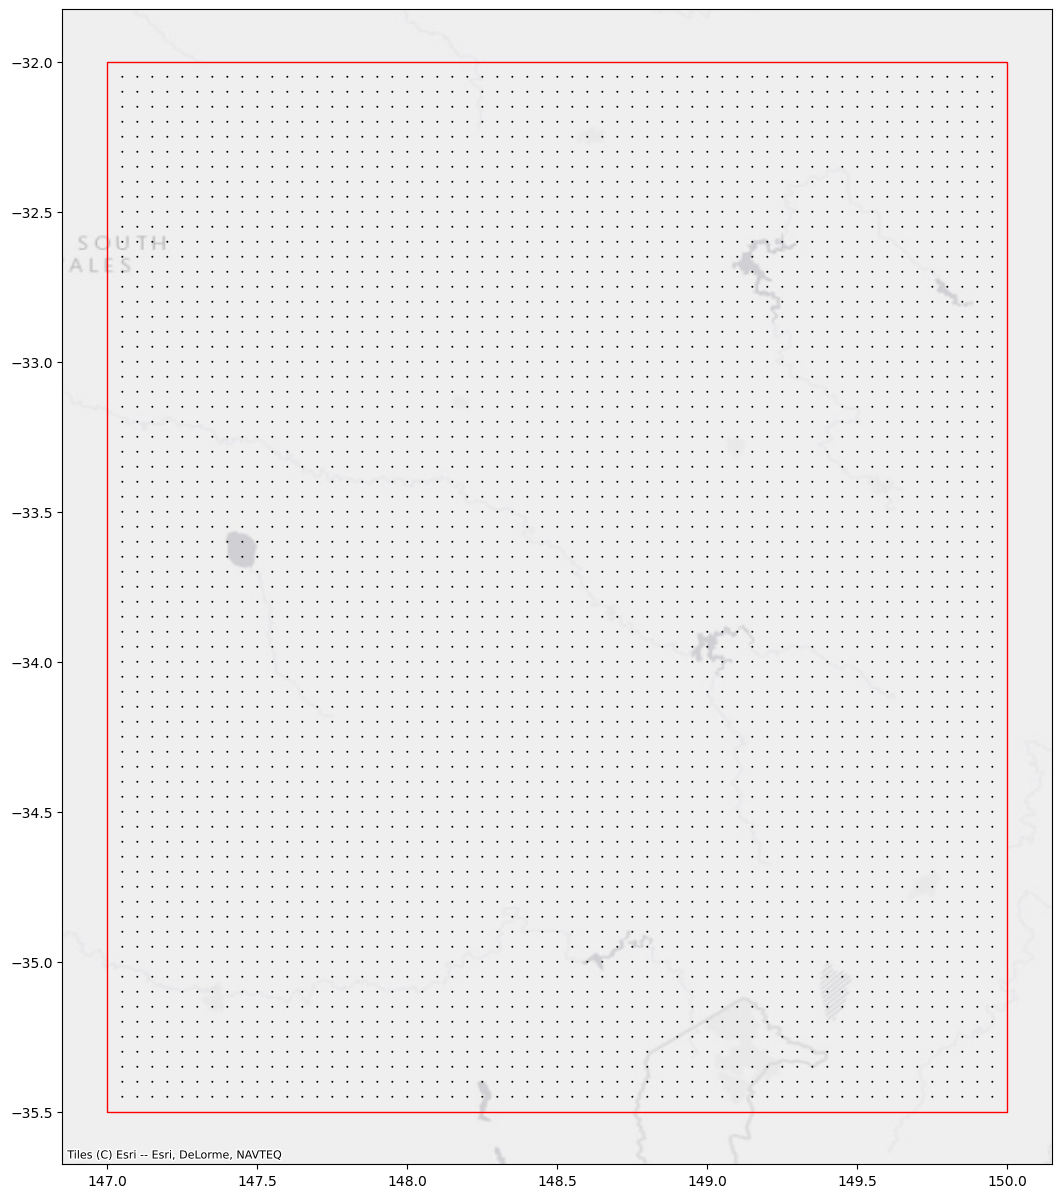

In [40]:
# set the sampling resolution
size_x = 0.05
size_y = 0.05

range_x = np.arange(extent_target[0], extent_target[1], size_x)
range_y = np.arange(extent_target[2], extent_target[3], size_y)

num_x = len(range_x)
num_y = len(range_y)

xs, ys = np.meshgrid(range_x, range_y)

target_coords_file = './Datasets/Outputs/target_coords.csv'
target_mask_file = './Datasets/Outputs/target_mask.csv'

# export the coordinates of the target points and create a mask to keep the points only inside the target polygon boundaries
if os.path.isfile(target_coords_file) and os.path.isfile(target_mask_file):
    print('The coordinates of target points already exist.')
    target_coords = pd.read_csv(target_coords_file, index_col=False)
    target_x = target_coords['X']
    target_y = target_coords['Y']
    target_mask = genfromtxt(target_mask_file, delimiter=',')
else:
    target_x = []
    target_y = []
    target_mask = []
    for xx, yy in zip(xs.flatten(), ys.flatten()):
        p = Point((xx, yy))
        if p.within(frame_target.geometry[0]):
            target_x.append(xx)
            target_y.append(yy)
            target_mask.append(True)
        else:
            target_mask.append(False)
    
    target_coords = pd.DataFrame(target_x, columns=['X'])
    target_coords['Y'] = target_y
    target_coords.to_csv(target_coords_file, index=False)
    
    mask_x = np.array([xs.flatten()]).T
    mask_y = np.array([ys.flatten()]).T
    target_mask_ = np.array([target_mask]).T
    target_mask = np.hstack((mask_x, mask_y, target_mask_))
    np.savetxt(target_mask_file, target_mask, delimiter=',')
    print('The coordinates of target points and mask have been saved.')

print(f'Number of samples: ', len(target_x))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(target_x, target_y, color='black', edgecolors='none', s=2)
frame_target.plot(ax=ax, edgecolor='red', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
plt.show()

#### Extract Values of Features at Target Points

In [41]:
target_lines_file = './Datasets/Outputs/target_lines.csv'

if os.path.isfile(target_lines_file):
    print('The lines dataset (traget points) already exists.')
    target_lines_data = pd.read_csv(target_lines_file, index_col=False)
else:
    target_lines_data = get_dist_line(target_x, target_y, line_files, distance_type='geodesic')
    target_lines_data = target_lines_data[target_lines_data.columns.intersection(deposit_lines_data.columns)]
    target_lines_data.to_csv(target_lines_file, index=False)
    print(f'The lines dataset (target points) has been saved to {target_lines_file}.')

target_cat_file = './Datasets/Outputs/target_categorical.csv'

if os.path.isfile(target_cat_file):
    print('The categorical dataset (target points) already exists.')
    target_cat_data = pd.read_csv(target_cat_file, index_col=False)
else:
    target_meta_fac = get_cat_data(target_x, target_y, meta_fac_files, field='MetFacies')
    target_intrusions = get_cat_data(target_x, target_y, intrusions_file, field='Dominant_L')
    target_rock_units = get_cat_data(target_x, target_y, rock_units_file, field='Dominant_L')
    target_cat_data = pd.concat([target_meta_fac, target_intrusions, target_rock_units], axis=1)
    target_cat_data = target_cat_data[target_cat_data.columns.intersection(deposit_cat_data.columns)]
    target_cat_data.to_csv(target_cat_file, index=False)
    print(f'The categorical dataset (target points) has been saved to {target_cat_file}.')

target_grid_file = './Datasets/Outputs/target_grids.csv'

if os.path.isfile(target_grid_file):
    print('The grid dataset (target points) already exists.')
    target_grid_data = pd.read_csv(target_grid_file, index_col=False)
else:
    target_grid_stat_data = get_grid_stat_features(target_x, target_y, grid_files, buffer_shape='square', buffer_size=10)
    target_grid_tex_data = get_grid_tex_features(target_x, target_y, grid_files, buffer_size=10)
    target_elev_stat_data = get_grid_grad_stat_features(target_x, target_y, elevation_file, buffer_shape='square', buffer_size=10)
    target_grid_data = pd.concat([target_grid_stat_data, target_grid_tex_data, target_elev_stat_data], axis=1)
    target_grid_data = target_grid_data[target_grid_data.columns.intersection(deposit_grid_data.columns)]
    target_grid_data.to_csv(target_grid_file, index=False)
    print(f'The grid dataset (target points) has been saved to {target_grid_file}.')

The lines dataset (traget points) already exists.
The categorical dataset (target points) already exists.
The grid dataset (target points) already exists.


In [42]:
# concatenate all the features generated in the previous cell
target_data_file = './Datasets/Outputs/target_data.csv'

if os.path.isfile(target_data_file):
    print('The target data file already exists.')
    target_data = pd.read_csv(target_data_file, index_col=False)
else:
    target_data = pd.concat([
        target_coords,
        target_grid_data,
        target_lines_data,
        target_cat_data],
        axis=1
    )
    target_data.to_csv(target_data_file, index=False)
    print(f'The target data file has been saved to {target_data_file}.')

target_features_file = './Datasets/Outputs/target_features.csv'

if os.path.isfile(target_features_file):
    print('The target features file already exists.')
    target_features = pd.read_csv(target_features_file, index_col=False)
    target_coords_purged = pd.read_csv('./Datasets/Outputs/target_coords_purged.csv', index_col=False)
    target_mask = genfromtxt(target_mask_file, delimiter=',')
else:
    index_null = target_data[target_data.isnull().any(axis=1)].index.to_list()

    for index in index_null:
        for i in range(target_mask.shape[0]):
            if target_data['X'][index] == target_mask[i, 0] and target_data['Y'][index] == target_mask[i, 1]:
                target_mask[i, 2] = False
                
    np.savetxt(target_mask_file, target_mask, delimiter=',')

    # remove missing values
    target_data = target_data.dropna()
    target_coords_purged = target_data[['X', 'Y']]
    target_coords_purged.to_csv('./Datasets/Outputs/target_coords_purged.csv', index=False)

    features_label_list = Xy_train_original.columns.tolist()
    features_list = features_label_list.copy()
    features_list = [e for e in features_list if e not in ('label', 'sample_weight')]
    num_features_list = []
    cat_features_list = []

    for column in features_list:
        if column.startswith('Intrusions_') or column.startswith('MetamorphicFacies') or column.startswith('RockUnits'):
            cat_features_list.append(column)
        else:
            num_features_list.append(column)
    
    # separate numerical and categorical features
    target_data_num = target_data[num_features_list]
    target_data_cat = target_data[deposit_cat_data_columns]

    st_scaler.fit(target_data_num)
    target_features_num = st_scaler.transform(target_data_num)
    target_features_cat = enc.transform(target_data_cat).toarray()
    target_features = np.hstack((target_features_num, target_features_cat))
    target_features = pd.DataFrame(target_features, columns=features_list)
    target_features.to_csv(target_features_file, index=False)
    print(f'The target features file has been saved to {target_data_file}.')

The target data file already exists.
The target features file already exists.


In [43]:
min_occ_clipped = min_occ.clip(frame_target)

@interact(feature=target_features.columns.tolist())
def show_map(feature):
    feature_values = []
    count = 0

    for mask in target_mask[:, 2]:
        if mask:
            feature_values.append(target_features.iloc[count][feature])
            count += 1
        else:
            feature_values.append(np.nan)

    feature_values_2d = np.reshape(feature_values, (num_y, num_x))
    fig, ax = plt.subplots(figsize=(15, 15))
    min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
    frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
    cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

    cb = plt.imshow(feature_values_2d, cmap=cmc.roma_r, origin='lower', interpolation='bilinear', extent=extent_target)

    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=feature, cax=cax)
    ax.set_title(feature)
    plt.show()

interactive(children=(Dropdown(description='feature', options=('Magmap2019-grid-tmi_1vd-AWAGS_MAG_2019_mean', …

### Calculate Probabilities

In [44]:
target_probs_file = './Datasets/Outputs/target_probs.csv'

if os.path.isfile(target_probs_file):
    print('The probability file already exists.')
    target_probs = pd.read_csv(target_probs_file, index_col=False)
else:
    probs = model_rf.predict_proba(target_features)
    
    mm_scaler = MinMaxScaler()
    probs_scaled = mm_scaler.fit_transform(probs[:, 1].reshape(-1, 1))
    
    target_probs = target_coords_purged.reset_index().copy()
    target_probs['prob'] = probs_scaled
    target_probs.to_csv(target_probs_file, index=False)
    print(f'The probability file has been saved to {target_probs_file}.')

The probability file already exists.


#### Plot Prospectivity Map

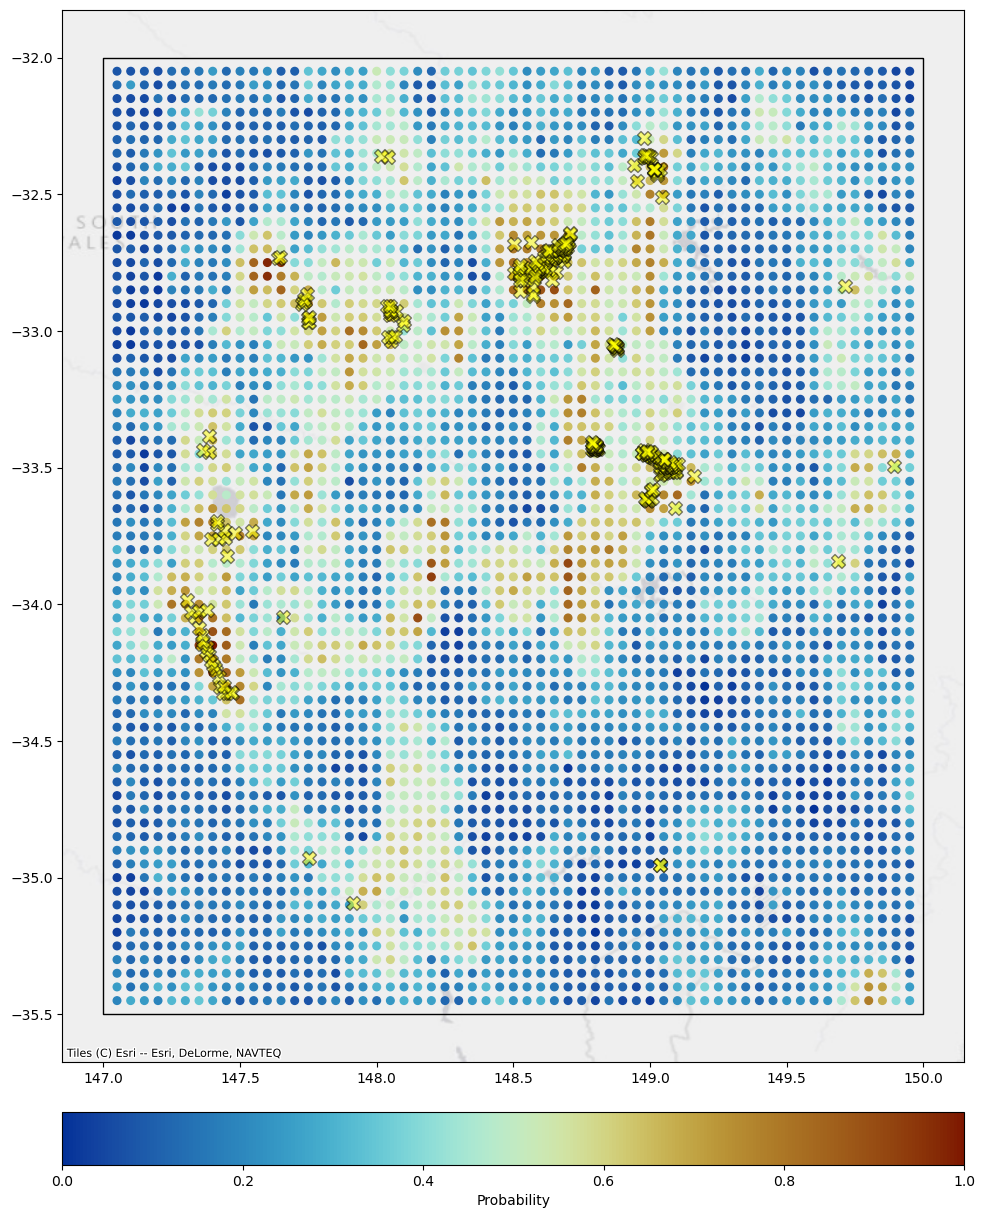

In [45]:
# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(target_probs['X'], target_probs['Y'], 30, c=target_probs['prob'], cmap=cmc.roma_r)
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)

frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

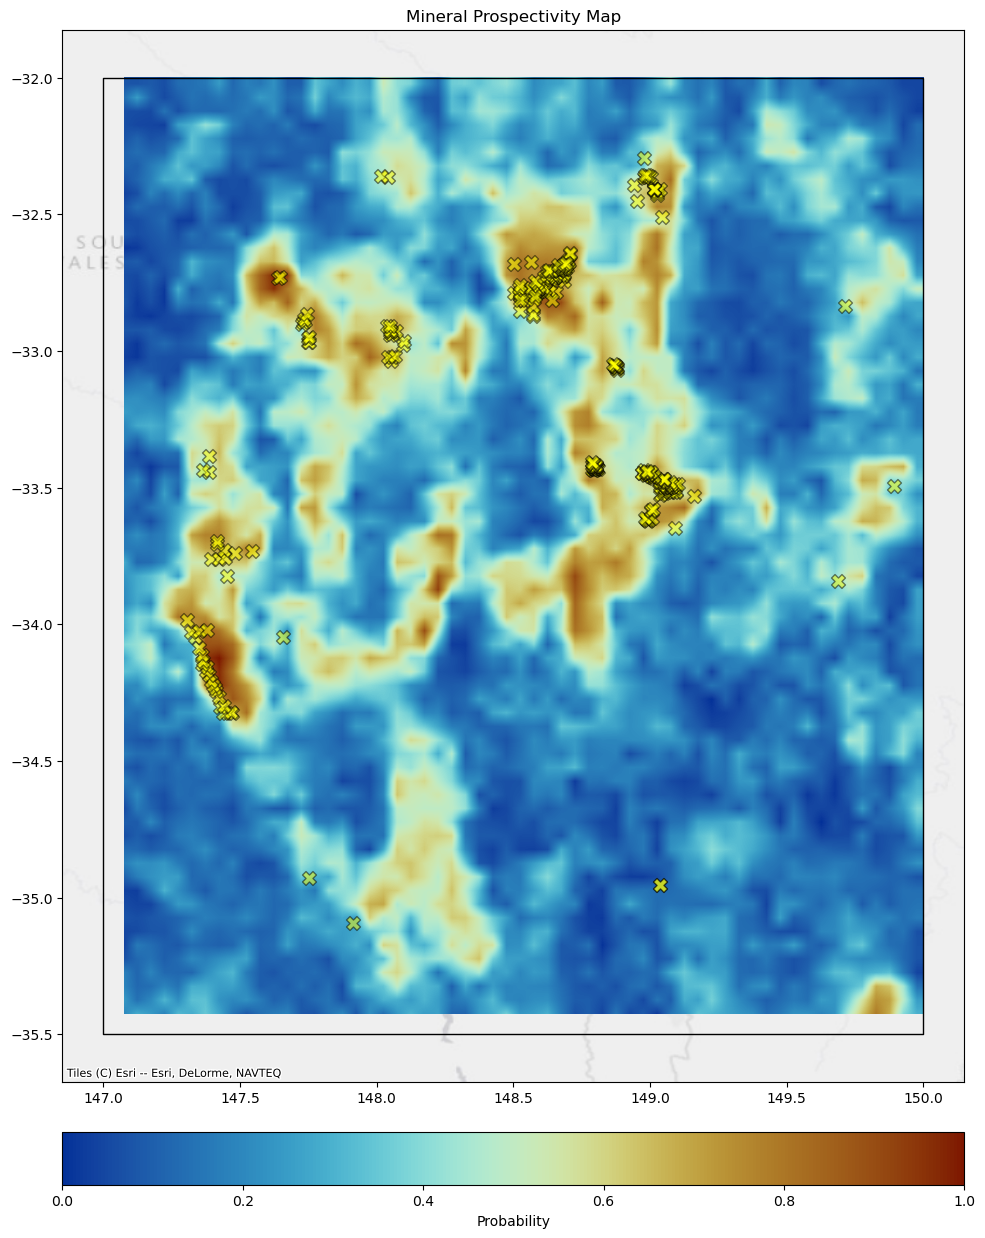

In [46]:
# create a probability map using the target points
probs_temp = []
count = 0

for mask in target_mask[:, 2]:
    if mask:
        probs_temp.append(target_probs['prob'][count])
        count += 1
    else:
        probs_temp.append(np.nan)

probs_2d = np.reshape(probs_temp, (num_y, num_x))

fig, ax = plt.subplots(figsize=(15, 15))
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

plt.imshow(probs_2d, cmap=cmc.roma_r, origin='lower', interpolation='bilinear', extent=extent_target)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Mineral Prospectivity Map')
plt.show()

In [47]:
probs_2d_ud = np.flipud(probs_2d)

probability_map_file = './Datasets/Outputs/probability_map.tif'

# export the map to a GeoTIFF file
if not os.path.isfile(probability_map_file):
    xmin, ymin, xmax, ymax = [min(range_x), min(range_y), max(range_x), max(range_y)]
    geotransform = (xmin, 0.05, 0, ymax, 0, -0.05)
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(probability_map_file, num_x, num_y, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geotransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4283)
    dataset.SetProjection(srs.ExportToWkt())
    dataset.GetRasterBand(1).WriteArray(probs_2d_ud)
    dataset.FlushCache()
    dataset = None

#### P-A Plot

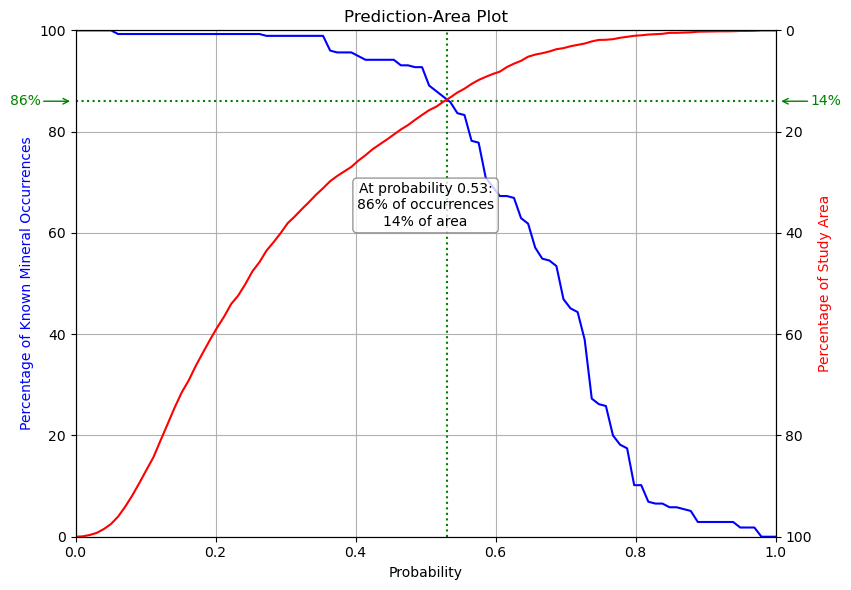

In [48]:
# Load the geotiff file (mineral prospectivity map) using rioxarray
prospectivity_data = rxr.open_rasterio('./Datasets/Outputs/probability_map.tif', masked=True).squeeze()

# Load the shapefile (mineral occurrences)
mineral_occurrences = gpd.read_file('./Datasets/Mineral Occurrences/MinView/GSNSWDataset/porphyry_target_frame.shp')

# Extract probability values at known mineral occurrence locations
occurrence_probabilities = []
for geom in mineral_occurrences.geometry:
    x, y = geom.x, geom.y
    # Extract probability value at this point
    prob_value = prospectivity_data.sel(x=x, y=y, method='nearest').item()
    occurrence_probabilities.append(prob_value)

# Convert to numpy array for easier manipulation
occurrence_probabilities = np.array(occurrence_probabilities)
occurrence_probabilities = occurrence_probabilities[~np.isnan(occurrence_probabilities)]

# Calculate total study area and the number of cells
total_area = np.count_nonzero(~np.isnan(prospectivity_data))
total_occurrences = len(occurrence_probabilities)

# Define the probability thresholds
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store results
occurrence_percentages = []
area_percentages = []

# Calculate percentages for each threshold
for threshold in thresholds:
    occurrence_percentage = np.sum(occurrence_probabilities >= threshold) / total_occurrences * 100
    area_percentage = np.sum(prospectivity_data >= threshold) / total_area * 100
    occurrence_percentages.append(occurrence_percentage)
    area_percentages.append(area_percentage)

# Convert lists to numpy arrays for plotting
occurrence_percentages = np.array(occurrence_percentages)
area_percentages = np.array(area_percentages)

# Create the P-A plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the occurrence percentages
ax1.plot(thresholds, occurrence_percentages, 'b-')
ax1.set_xlabel('Probability')
ax1.set_ylabel('Percentage of Known Mineral Occurrences', color='b')
ax1.set_ylim(0, 100)
ax1.set_xlim(0, 1)
ax1.grid(True)  # Add grid to the first y-axis

# Create a second y-axis to plot the area percentages
ax2 = ax1.twinx()
ax2.plot(thresholds, area_percentages, 'r-')
ax2.set_ylabel('Percentage of Study Area', color='r')
ax2.set_ylim(100, 0)  # Inverted y-axis

# Add horizontal and vertical lines
intersection_x = 0.53
intersection_y1 = 86
intersection_y2 = 14
h_line = ax1.hlines(y=intersection_y1, xmin=0, xmax=1, color='g', linestyles=':')
v_line = ax1.vlines(x=intersection_x, ymin=0, ymax=100, color='g', linestyles=':')

# Add annotations for the lines
# X-axis annotation
# ax1.annotate(f'{intersection_x}', xy=(intersection_x, -0.06), xycoords='data',
#              xytext=(0, -20), textcoords='offset points',
#              ha='center', va='top', color='g',
#              arrowprops=dict(arrowstyle='->', color='g'))

# Left Y-axis (Percentage of Known Mineral Occurrences) annotation
ax1.annotate(f'{intersection_y1}%', xy=(0, intersection_y1), xycoords='data',
             xytext=(-25, 0), textcoords='offset points',
             ha='right', va='center', color='g',
             arrowprops=dict(arrowstyle='->', color='g', shrinkA=0, shrinkB=4))

# Right Y-axis (Percentage of Study Area) annotation
ax2.annotate(f'{intersection_y2}%', xy=(1, intersection_y2), xycoords='data',
             xytext=(25, 0), textcoords='offset points',
             ha='left', va='center', color='g',
             arrowprops=dict(arrowstyle='->', color='g', shrinkA=0, shrinkB=4))

# Add a text box to explain the intersection point
ax1.annotate(f'At probability {intersection_x}:\n{intersection_y1}% of occurrences\n{intersection_y2}% of area',
             xy=(0.5, 0.7), xycoords='axes fraction',
             ha='center', va='top',
             bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

plt.title('Prediction-Area Plot')
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Adjust the plot margins to make room for annotations
plt.subplots_adjust(left=0.15, right=0.85)

plt.show()

### Select Important Features

In [49]:
features_important = []

for i in range(len(features_importance)):
    if features_importance[i][1] >= 0.01:
        features_important.append(features_importance[i][0])

Xy_important_train_file = './Datasets/Outputs/Xy_important_train.csv'
Xy_important_test_file = './Datasets/Outputs/Xy_important_test.csv'

if os.path.isfile(Xy_important_train_file) and os.path.isfile(Xy_important_test_file):
    print('The training data file already exists.')
    Xy_important_train = pd.read_csv(Xy_important_train_file, index_col=False)
    Xy_important_test = pd.read_csv(Xy_important_test_file, index_col=False)
else:
    features_important.append('sample_weight')
    features_important.append('label')
    # features_important.remove()

    Xy_train_file = './Datasets/Outputs/Xy_train.csv'
    Xy_pos_test_file = './Datasets/Outputs/Xy_pos_test.csv'

    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    Xy_pos_test = pd.read_csv(Xy_pos_test_file, index_col=False)

    Xy_important_train = Xy_train[features_important]
    Xy_pos_important_test = Xy_pos_test[features_important]

    Xy_important_train.to_csv('./Datasets/Outputs/Xy_important_train.csv', index=False)
    Xy_pos_important_test.to_csv('./Datasets/Outputs/Xy_pos_important_test.csv', index=False)

### Positive and Unlabelled Bagging

In [50]:
model_pub_important_file = './Datasets/Outputs/model_pub_important.pkl'

if os.path.isfile(model_pub_important_file):
    print('A PUB model file exists. Attempting to load...')
    try:
        with open(model_pub_important_file, 'rb') as f:
            model_pub_important = pickle.load(f)
        print('Model loaded successfully.')
    except (ModuleNotFoundError, ImportError) as e:
        print(f"Error loading the model: {e}")
        print("This may be due to a version mismatch. Proceeding to train a new model.")
        model_pub_important = None
else:
    print('No existing model found. Proceeding to train a new model.')
    model_pub_important = None

if model_pub_important is None:
    # Random Forest model structure
    rf_pub_important = RandomForestClassifier(n_jobs=-1, random_state=42)
    pub_important = BaggingPuClassifier(rf_pub_important, n_jobs=-1, random_state=42)

    n_fold = 10

    Xy_train_file = f'./Datasets/Outputs/Xy_important_train.csv'
    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    features = Xy_train[Xy_train.columns[:-1]]
    labels = Xy_train[Xy_train.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=42)
    
    Xy_pub_train = np.hstack((X_train, y_train.values.reshape(-1, 1)))
    Xy_pub_train = pd.DataFrame(Xy_pub_train, columns=Xy_train.columns)
    Xy_pub_train.to_csv('./Datasets/Outputs/Xy_pub_important_train.csv', index=False)
    
    Xy_pub_test = np.hstack((X_test, y_test.values.reshape(-1, 1)))
    Xy_pub_test = pd.DataFrame(Xy_pub_test, columns=Xy_train.columns)
    Xy_pub_test.to_csv('./Datasets/Outputs/Xy_pub_important_test.csv', index=False)

    weights_train = X_train[X_train.columns[-1]]
    X_train = X_train[X_train.columns[:-1]]
    weights_test = X_test[X_test.columns[-1]]
    X_test = X_test[X_test.columns[:-1]]

    search_space = {
    'base_estimator__bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
    'base_estimator__max_depth': Integer(5, 20), # values of max_depth are integers
    'base_estimator__max_features': Categorical([None, 'sqrt','log2']), 
    'base_estimator__min_samples_leaf': Integer(2, 20),
    'base_estimator__min_samples_split': Integer(2, 30),
    'base_estimator__n_estimators': Integer(10, 200),
    'max_samples': Integer(int(0.5*(len(y_train)-sum(y_train))), int(0.9*(len(y_train)-sum(y_train))))
    }

    pub_bayes_search = BayesSearchCV(pub_important,
                                     search_space,
                                     n_iter=50, # specify how many iterations
                                     scoring='f1',
                                     n_jobs=4,
                                     cv=n_fold,
                                     verbose=1,
                                     random_state=42)
    pub_bayes_search.fit(X_train, y_train, sample_weight=weights_train)
    
    # Extract the optimization results
    optimization_results = pub_bayes_search.cv_results_['mean_test_score']

    model_pub_important = pub_bayes_search.best_estimator_
    model_pub_important_acc = pub_bayes_search.best_score_    
    print('The highest accuracy during cross validation:', model_pub_important_acc)
    
    # save the model
    with open(model_pub_important_file, 'wb') as f:
        pickle.dump(model_pub_important, f)
    
    # Plot the Bayesian optimization progress
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(optimization_results) + 1), optimization_results, marker='o', color='black', markerfacecolor='red')
    plt.xlim(0, 51)
    plt.xlabel('Bayesian Optimization Iteration')
    plt.ylabel('Mean Test Precision')
    plt.title('Bayesian Optimization Progress')
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.savefig('./Datasets/Outputs/bayesian_optimization_pub_important_progress.png')
    plt.show()

A PUB model file exists. Attempting to load...
Model loaded successfully.


In [51]:
print(model_pub_important)

Xy_pub_test_file = f'./Datasets/Outputs/Xy_pub_important_test.csv'
Xy_pub_test = pd.read_csv(Xy_pub_test_file, index_col=False)

features = Xy_pub_test[Xy_pub_test.columns[:-2]]
labels = Xy_pub_test[Xy_pub_test.columns[-1]]
weights = Xy_pub_test[Xy_pub_test.columns[-2]]

X_pred = model_pub_important.predict(features)

# assuming that all zeros in labels are true negative samples
cMatrix = confusion_matrix(labels, X_pred)
X_pred_acc = accuracy_score(labels, X_pred, sample_weight=weights)
X_pred_pre = precision_score(labels, X_pred, sample_weight=weights)
X_pred_rec = recall_score(labels, X_pred, sample_weight=weights)
X_pred_f1 = f1_score(labels, X_pred, sample_weight=weights)

print('Confusion matrix:\n', cMatrix)
print('Accuracy:', X_pred_acc)
print('Precision:', X_pred_pre)
print('Recall:', X_pred_rec)
print('F1-Score:', X_pred_f1)

BaggingPuClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                          max_depth=5,
                                                          max_features='log2',
                                                          min_samples_leaf=2,
                                                          n_estimators=200,
                                                          n_jobs=-1,
                                                          random_state=42),
                    max_samples=115, n_jobs=-1, random_state=42)
Confusion matrix:
 [[63  1]
 [ 4 52]]
Accuracy: 0.9693877551020408
Precision: 0.9285714285714284
Recall: 0.9027777777777777
F1-Score: 0.9154929577464787


In [52]:
Xy_pos_test = pd.read_csv('./Datasets/Outputs/Xy_pos_important_test.csv', index_col=False)
X_pos_test = Xy_pos_test[Xy_pos_test.columns[:-2]]
y_pos_test = Xy_pos_test[Xy_pos_test.columns[-1]]
weights_test = Xy_pos_test[Xy_pos_test.columns[-2]]
X_pos_pred = model_pub_important.predict(X_pos_test)
X_pos_pred_acc = accuracy_score(y_pos_test, X_pos_pred, sample_weight=weights_test)
print('Accuracy:', X_pos_pred_acc)

Accuracy: 0.923076923076923


In [53]:
Xy_train = pd.read_csv('./Datasets/Outputs/Xy_important_train.csv', index_col=False)
Xy_train_features = Xy_train[Xy_train.columns[:-2]]
Xy_train_labels = Xy_train[Xy_train.columns[-1]]
Xy_train_weights = Xy_train[Xy_train.columns[-2]]
Xy_train_labels_new = model_pub_important.predict(Xy_train_features)

Xy_train_labels_new_acc = accuracy_score(Xy_train_labels, Xy_train_labels_new, sample_weight=Xy_train_weights)
Xy_train_labels_new_pre = precision_score(Xy_train_labels, Xy_train_labels_new, sample_weight=Xy_train_weights)
Xy_train_labels_new_rec = recall_score(Xy_train_labels, Xy_train_labels_new, sample_weight=Xy_train_weights)
Xy_train_labels_new_f1 = f1_score(Xy_train_labels, Xy_train_labels_new, sample_weight=Xy_train_weights)

# assuming that all zeros in Xy_train_labels are true negative samples
print('Accuracy:', Xy_train_labels_new_acc)
print('Precision:', Xy_train_labels_new_pre)
print('Recall:', Xy_train_labels_new_rec)
print('F1-Score:', Xy_train_labels_new_f1)

Xy_important_train_new_file = './Datasets/Outputs/Xy_important_train_new.csv'

if os.path.isfile(Xy_important_train_new_file):
    Xy_important_train_new = pd.read_csv(Xy_important_train_new_file, index_col=False)
else:
    mask = Xy_train_labels == 1
    Xy_train_labels_new[mask] = 1
    Xy_train['label'] = Xy_train_labels_new
    Xy_train.to_csv(Xy_important_train_new_file, index=False)

Accuracy: 0.977884040645547
Precision: 0.9107142857142859
Recall: 0.9776357827476038
F1-Score: 0.942989214175655


### Create the Predictive Model

In [54]:
model_rf_important_file = './Datasets/Outputs/model_rf_important.pkl'

if os.path.isfile(model_rf_important_file):
    print('A model file exists. Attempting to load...')
    try:
        with open(model_rf_important_file, 'rb') as f:
            model_rf_important = pickle.load(f)
        print('Model loaded successfully.')
    except (ModuleNotFoundError, ImportError) as e:
        print(f"Error loading the model: {e}")
        print("This may be due to a version mismatch. Proceeding to train a new model.")
        model_rf_important = None
else:
    print('No existing model found. Proceeding to train a new model.')
    model_rf_important = None

if model_rf_important is None:
    # Random Forest model structure
    rf_important = RandomForestClassifier(n_jobs=-1, random_state=42)

    n_fold = 10

    Xy_train_file = f'./Datasets/Outputs/Xy_important_train_new.csv'
    Xy_train = pd.read_csv(Xy_train_file, index_col=False)
    features = Xy_train[Xy_train.columns[:-1]]
    labels = Xy_train[Xy_train.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=42)

    Xy_rf_train = np.hstack((X_train, y_train.values.reshape(-1, 1)))
    Xy_rf_train = pd.DataFrame(Xy_rf_train, columns=Xy_train.columns)
    Xy_rf_train.to_csv('./Datasets/Outputs/Xy_rf_important_train.csv', index=False)
    
    Xy_rf_test = np.hstack((X_test, y_test.values.reshape(-1, 1)))
    Xy_rf_test = pd.DataFrame(Xy_rf_test, columns=Xy_train.columns)
    Xy_rf_test.to_csv('./Datasets/Outputs/Xy_rf_important_test.csv', index=False)

    weights_train = X_train[X_train.columns[-1]]
    X_train = X_train[X_train.columns[:-1]]
    weights_test = X_test[X_test.columns[-1]]
    X_test = X_test[X_test.columns[:-1]]

    search_space = {
    'bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
    'max_depth': Integer(5, 20), # values of max_depth are integers
    'max_features': Categorical([None, 'sqrt','log2']), 
    'min_samples_leaf': Integer(2, 20),
    'min_samples_split': Integer(2, 30),
    'n_estimators': Integer(10, 200)
    }

    rf_bayes_search = BayesSearchCV(rf_important,
                                    search_space,
                                    n_iter=50, # specify how many iterations
                                    scoring='f1',
                                    n_jobs=4,
                                    cv=n_fold,
                                    verbose=1,
                                    random_state=42)
    rf_bayes_search.fit(X_train, y_train, sample_weight=weights_train)
    
    # Extract the optimization results
    optimization_results = rf_bayes_search.cv_results_['mean_test_score']

    model_rf_important = rf_bayes_search.best_estimator_
    model_rf_important_acc = rf_bayes_search.best_score_ 
    print('The highest accuracy during cross validation:', model_rf_important_acc)
    
    # save the model
    with open('./Datasets/Outputs/model_rf_important.pkl', 'wb') as f:
        pickle.dump(model_rf_important, f)
    
    importances = []
    estimators = model_rf_important.estimators_
    importances = [estimators[j].feature_importances_.reshape(-1, 1) for j in range(len(estimators))]
    importances = np.hstack(importances)

    # Plot the Bayesian optimization progress
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(optimization_results) + 1), optimization_results, marker='o', color='black', markerfacecolor='red')
    plt.xlim(0, 51)
    plt.xlabel('Bayesian Optimization Iteration')
    plt.ylabel('Mean Test Accuracy')
    plt.title('Bayesian Optimization Progress')
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.savefig('./Datasets/Outputs/bayesian_optimization_rf_important_progress.png')
    plt.show()
else:
    print("Using the loaded model. No new training performed.")
    print("To retrain the model, delete or rename the existing model file and run the script again.")

print("Script execution completed.")

A model file exists. Attempting to load...
Model loaded successfully.
Using the loaded model. No new training performed.
To retrain the model, delete or rename the existing model file and run the script again.
Script execution completed.


In [55]:
print(model_rf_important)

Xy_rf_test_file = f'./Datasets/Outputs/Xy_rf_important_test.csv'
Xy_rf_test = pd.read_csv(Xy_rf_test_file, index_col=False)

features = Xy_rf_test[Xy_rf_test.columns[:-2]]
labels = Xy_rf_test[Xy_rf_test.columns[-1]]
weights = Xy_rf_test[Xy_rf_test.columns[-2]]

X_pred = model_rf_important.predict(features)

cMatrix = confusion_matrix(labels, X_pred)
X_pred_acc = accuracy_score(labels, X_pred, sample_weight=weights)
X_pred_pre = precision_score(labels, X_pred, sample_weight=weights)
X_pred_rec = recall_score(labels, X_pred, sample_weight=weights)
X_pred_f1 = f1_score(labels, X_pred, sample_weight=weights)

print('Confusion matrix:\n', cMatrix)
print('Accuracy:', X_pred_acc)
print('Precision:', X_pred_pre)
print('Recall:', X_pred_rec)
print('F1-Score:', X_pred_f1)

RandomForestClassifier(bootstrap=False, max_depth=19, min_samples_leaf=2,
                       n_estimators=194, n_jobs=-1, random_state=42)
Confusion matrix:
 [[63  0]
 [ 5 52]]
Accuracy: 0.9795918367346937
Precision: 1.0
Recall: 0.8961038961038961
F1-Score: 0.9452054794520548


In [56]:
Xy_pos_test = pd.read_csv('./Datasets/Outputs/Xy_pos_important_test.csv', index_col=False)
X_pos_test = Xy_pos_test[Xy_pos_test.columns[:-2]]
y_pos_test = Xy_pos_test[Xy_pos_test.columns[-1]]
weights_test = Xy_pos_test[Xy_pos_test.columns[-2]]
X_pos_pred = model_rf_important.predict(X_pos_test)
X_pos_pred_acc = accuracy_score(y_pos_test, X_pos_pred, sample_weight=weights_test)
print('Accuracy:', X_pos_pred_acc)

Accuracy: 0.923076923076923


#### ROC Plot

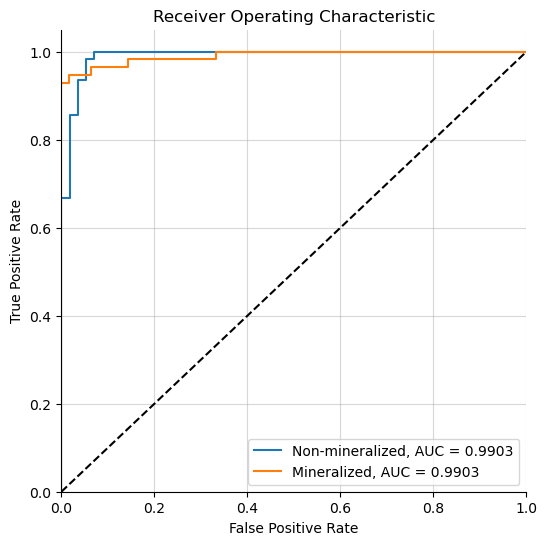

ROC AUC score: 0.9902534113060429


In [57]:
# predict for the test dataset
z_test = model_rf_important.predict_proba(features)

labels_name = ['Non-mineralized', 'Mineralized']
roc_plot(labels, z_test, 2, labels_name)

#### Feature Importance

In [58]:
features_importance_important_file = './Datasets/Outputs/features_importance_important.csv'

if os.path.isfile(features_importance_important_file):
    features_importance_important = pd.read_csv(features_importance_important_file, index_col=False).to_numpy().tolist()
else:
    importances_mean = importances.mean(axis=1)
    importances_var = importances.var(axis=1)

    features_important = [e for e in features_important if e not in ('label', 'sample_weight')]
    features_importance_important = [(feature, round(importance, 5)) for feature, importance in zip(features_important, importances_mean)]

    features_importance_important = sorted(features_importance_important, key=lambda x:x[1], reverse=True)
    features_importance_important_df = pd.DataFrame(features_importance_important, columns=['Feature', 'Importance'])
    features_importance_important_df['Variance'] = importances_var
    features_importance_important_df.to_csv(features_importance_important_file, index=False)

Text(0, 0.5, 'Cumulative Importance')

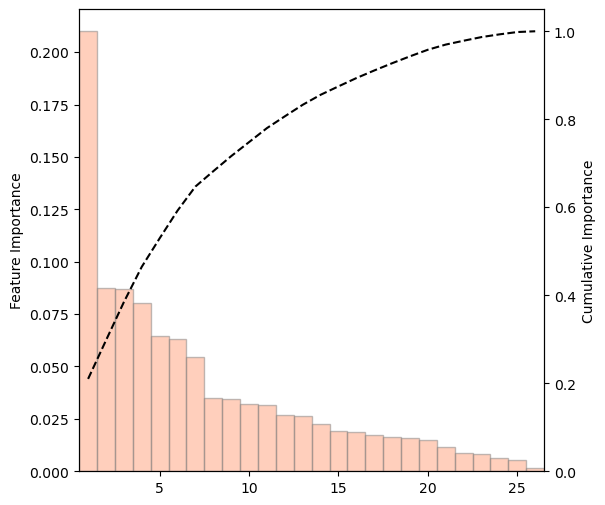

In [59]:
# list of features sorted from most to least important
sorted_importances = [importance[1] for importance in features_importance_important]
# cumulative importance
cumulative_importances = np.cumsum(sorted_importances)

x_values = list(range(len(features_importance_important)))
x_values = [x+1 for x in x_values]

fig = plt.figure(figsize=(6, 6))
ax2 = fig.add_subplot(111)
ax1 = ax2.twinx()

ax2.bar(x_values, sorted_importances, edgecolor='gray', facecolor='LightSalmon', width=1, alpha=0.5)
ax1.plot(x_values, cumulative_importances, 'k--')

plt.xticks(rotation=30)
plt.xlim(0.5, len(cumulative_importances)+0.5)

ax1.set_ylim(0, 1.05)

ax2.set_ylabel('Feature Importance')
ax1.set_ylabel('Cumulative Importance')

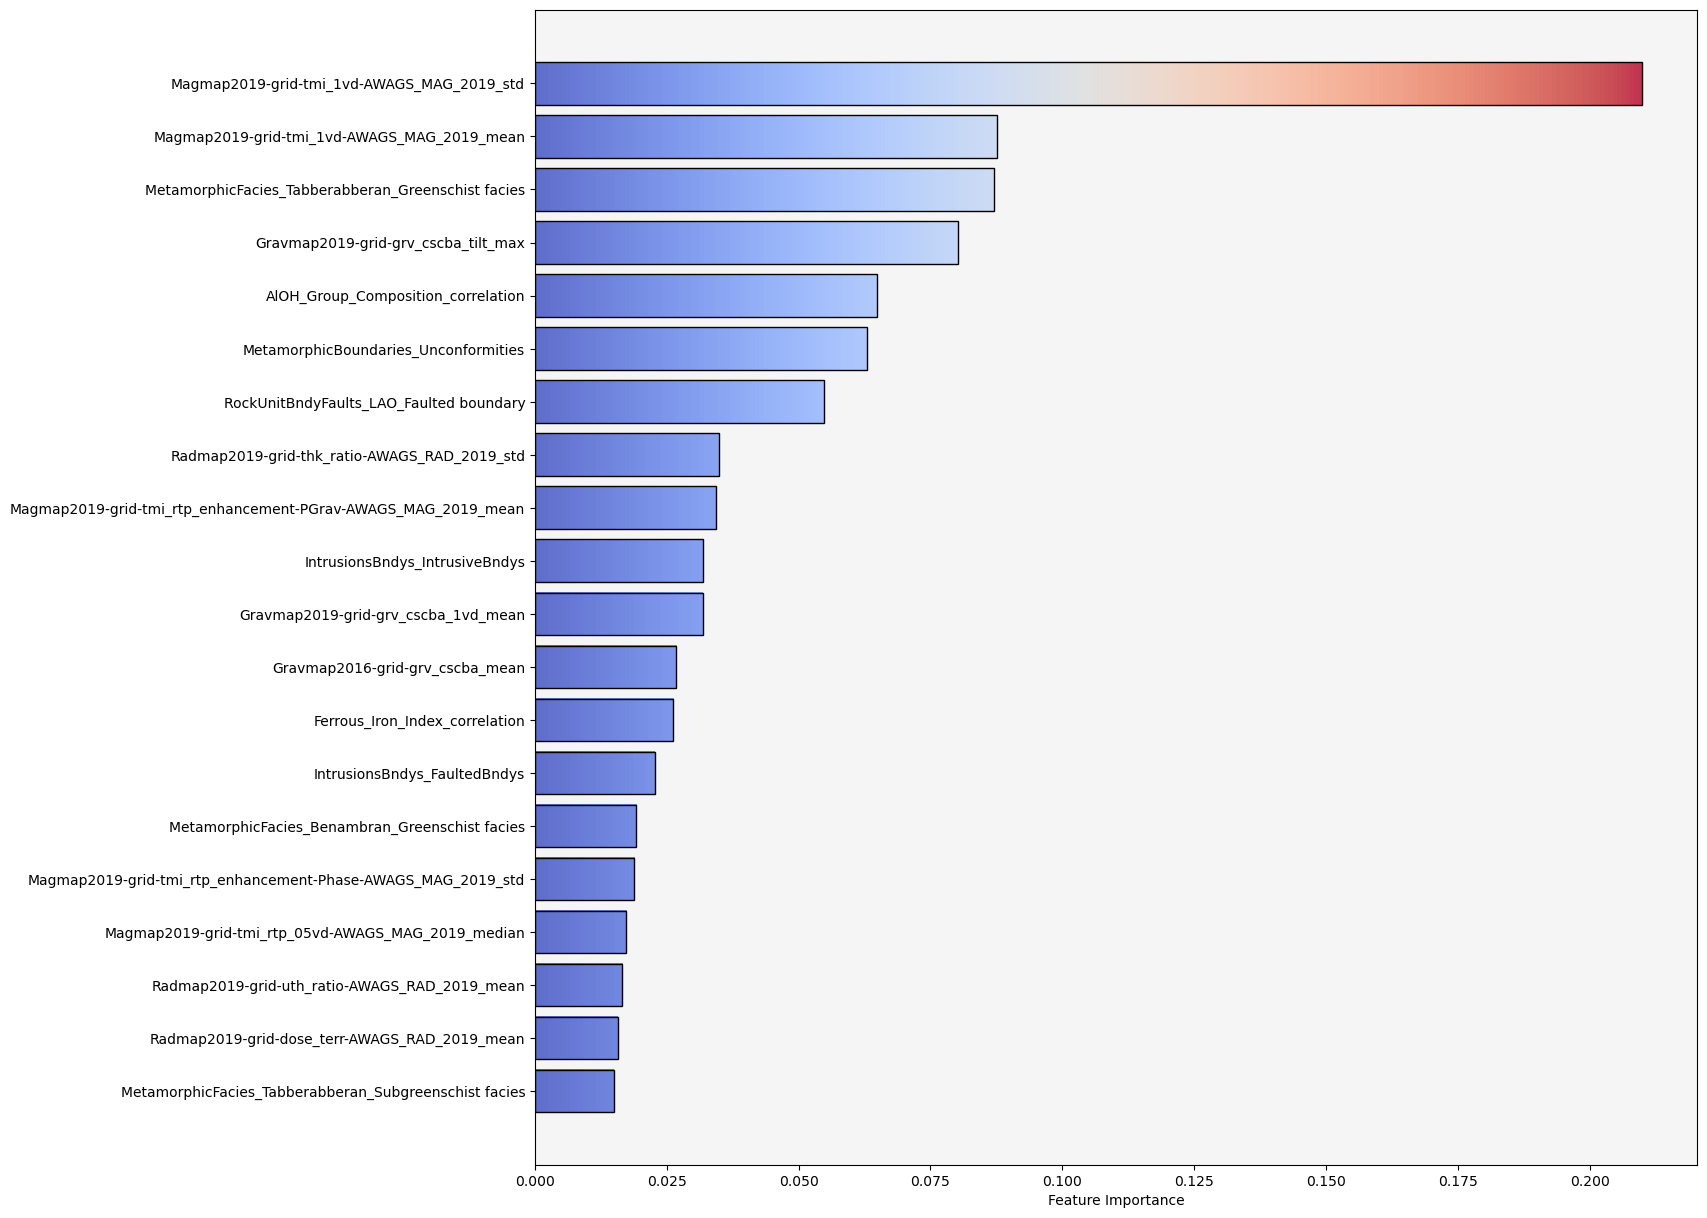

In [60]:
# print significant features above some threshold
features_importance_top = features_importance_important[:20]
features_importance_top.sort(key=lambda x:x[1])
ft_imps = [x[1] for x in features_importance_top]

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_facecolor('whitesmoke')
bar = ax.barh(range(len(ft_imps)), ft_imps)

def gradientbars(bars, data):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        bar.set_edgecolor('black')
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        cmap = plt.get_cmap('coolwarm')
        grad = np.atleast_2d(np.linspace(0, 1*w/max(data), 256))
        ax.imshow(grad, extent=[x, x+w, y, y+h], aspect='auto', zorder=0, norm=mpl.colors.NoNorm(vmin=0, vmax=1), cmap=cmap, alpha=0.8)
        manual_labels = [x[0] for x in features_importance_top]
        ax.set_yticks(np.arange(0, len(data), 1).tolist())
        ax.set_yticklabels(manual_labels, minor=False)
    ax.axis(lim)
    ax.set_xlabel('Feature Importance')

gradientbars(bar, ft_imps)
plt.gca().yaxis.grid(False)
plt.show()

### Calculate Probabilities

In [61]:
target_probs_important_file = './Datasets/Outputs/target_probs_important.csv'

if os.path.isfile(target_probs_important_file):
    print('The probability file already exists.')
    target_probs_important = pd.read_csv(target_probs_important_file, index_col=False)
else:
    try:
        features_important = [e for e in features_important if e not in ('label', 'sample_weight')]
        probs = model_rf_important.predict_proba(target_features[features_important])
    except:
        probs = model_rf_important.predict_proba(target_features[features_important])
    
    mm_scaler = MinMaxScaler()
    probs_scaled = mm_scaler.fit_transform(probs[:, 1].reshape(-1, 1))
    
    target_probs_important = target_coords_purged.reset_index().copy()
    target_probs_important['prob'] = probs_scaled
    target_probs_important.to_csv(target_probs_important_file, index=False)
    print(f'The probability file has been saved to {target_probs_important_file}.')

The probability file already exists.


#### Plot Prospectivity Map

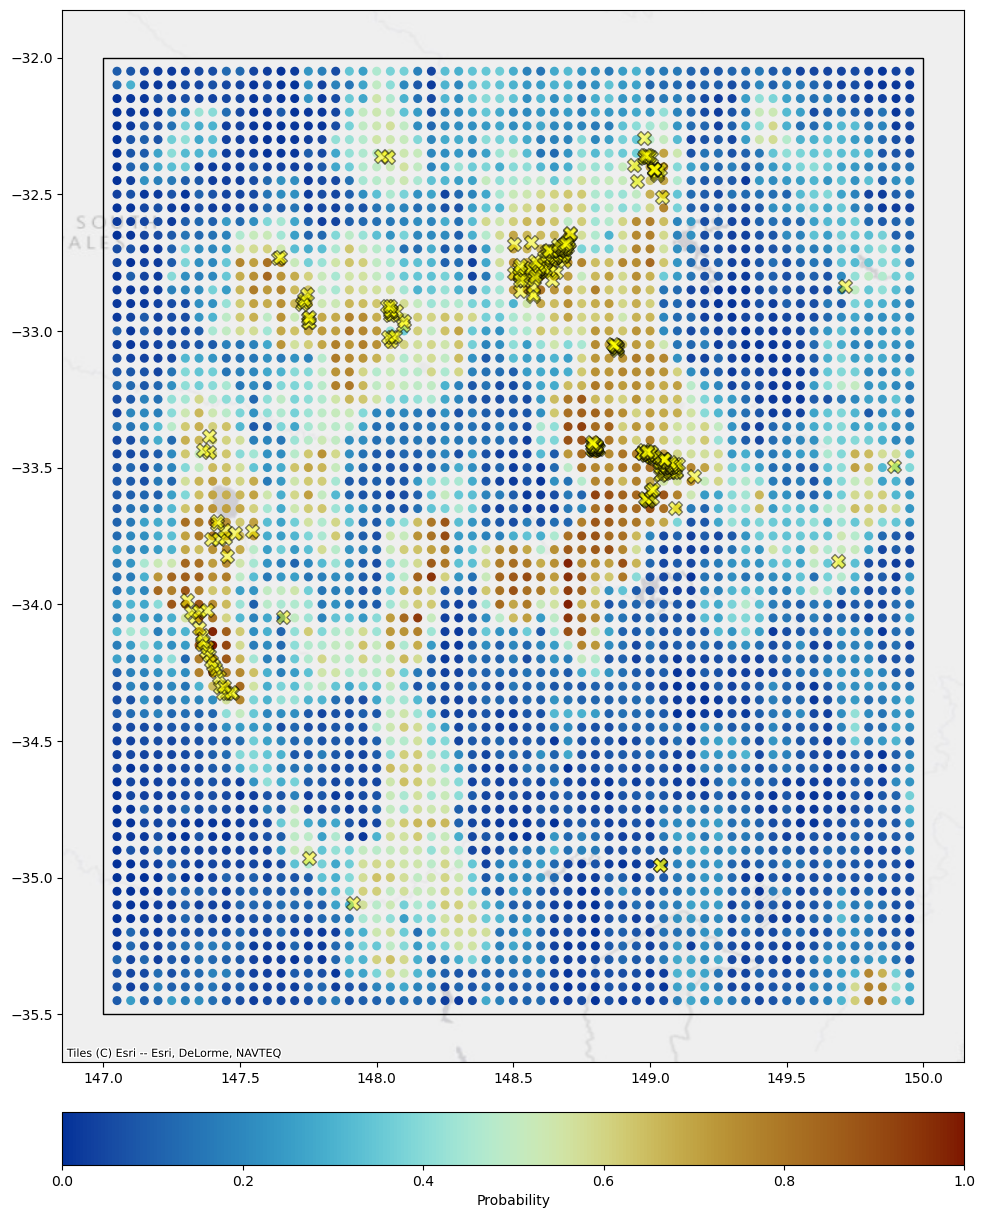

In [62]:
min_occ_clipped = min_occ.clip(frame_target)

# plot the probability map
fig, ax = plt.subplots(figsize=(15, 15))
cb = plt.scatter(target_probs_important['X'], target_probs_important['Y'], 30, c=target_probs_important['prob'], cmap=cmc.roma_r)
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)

frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)
# colorbar
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
plt.show()

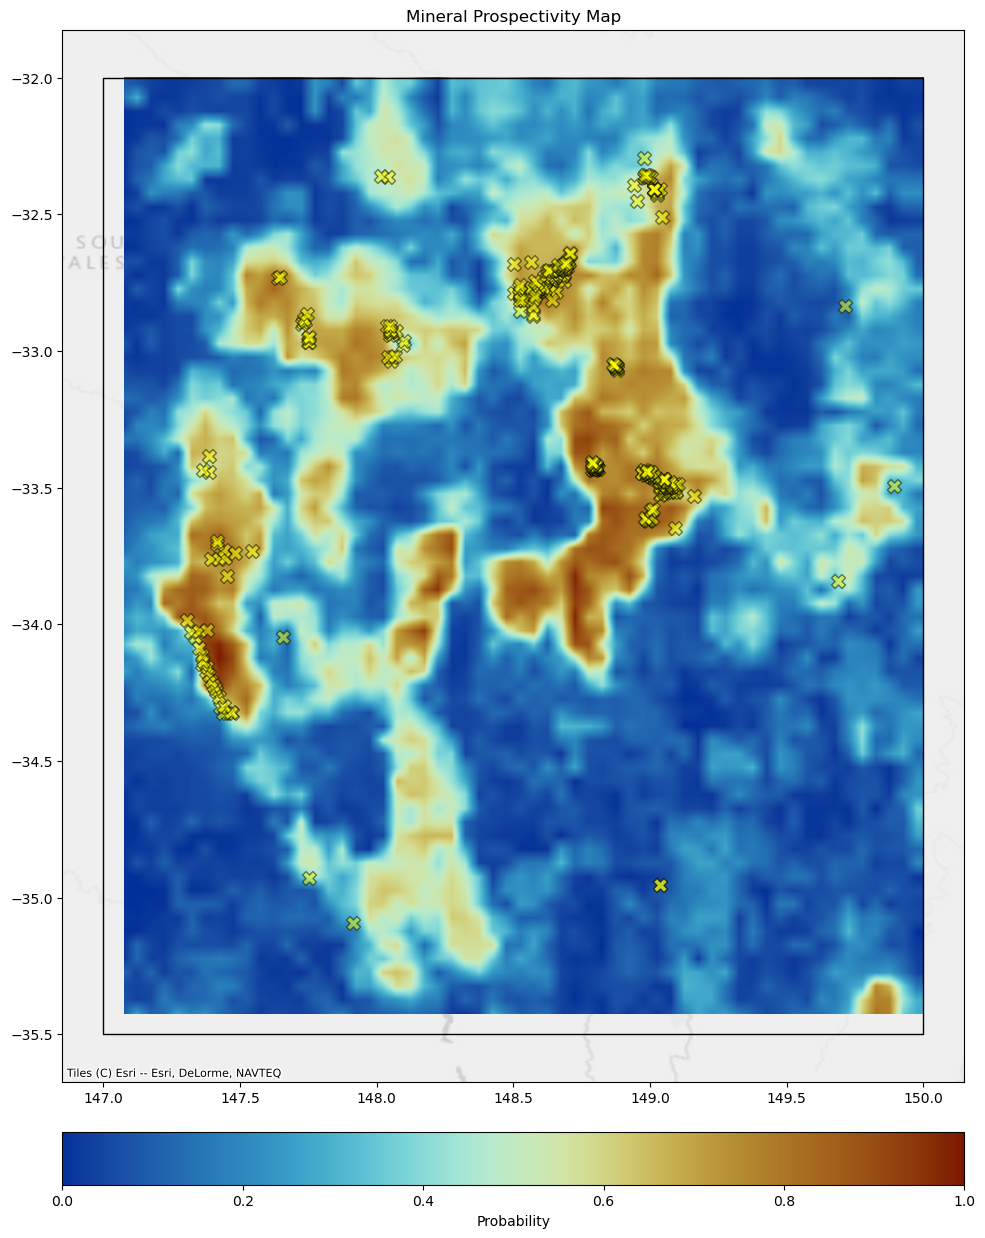

In [63]:
# create a probability map using the target points
probs_temp = []
count = 0

for mask in target_mask[:, 2]:
    if mask:
        probs_temp.append(target_probs_important['prob'][count])
        count += 1
    else:
        probs_temp.append(np.nan)

probs_2d = np.reshape(probs_temp, (num_y, num_x))

fig, ax = plt.subplots(figsize=(15, 15))
min_occ_clipped.plot(ax=ax, marker='X', edgecolor='black', color='yellow', markersize=100, alpha=0.5)
frame_target.plot(ax=ax, edgecolor='black', color='none', linewidth=1)
cx.add_basemap(ax, crs='EPSG:4283', source=cx.providers.Esri.WorldGrayCanvas)

plt.imshow(probs_2d, cmap=cmc.roma_r, origin='lower', interpolation='bilinear', extent=extent_target)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
plt.colorbar(cb, orientation='horizontal', label='Probability', cax=cax)
ax.set_title(f'Mineral Prospectivity Map')
plt.show()

In [64]:
probs_2d_ud = np.flipud(probs_2d)

probability_map_important_file = './Datasets/Outputs/probability_map_important.tif'

# export the map to a GeoTIFF file
if not os.path.isfile(probability_map_important_file):
    xmin, ymin, xmax, ymax = [min(range_x), min(range_y), max(range_x), max(range_y)]
    geotransform = (xmin, 0.05, 0, ymax, 0, -0.05)
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(probability_map_important_file, num_x, num_y, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geotransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4283)
    dataset.SetProjection(srs.ExportToWkt())
    dataset.GetRasterBand(1).WriteArray(probs_2d_ud)
    dataset.FlushCache()
    dataset = None

#### P-A Plot

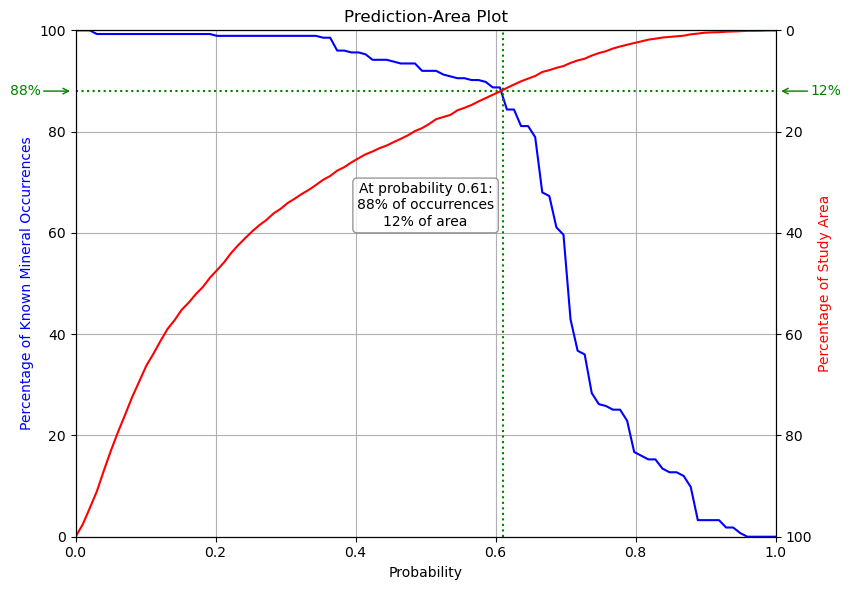

In [65]:
# Load the geotiff file (mineral prospectivity map) using rioxarray
prospectivity_data = rxr.open_rasterio('./Datasets/Outputs/probability_map_important.tif', masked=True).squeeze()

# Load the shapefile (mineral occurrences)
mineral_occurrences = gpd.read_file('./Datasets/Mineral Occurrences/MinView/GSNSWDataset/porphyry_target_frame.shp')

# Extract probability values at known mineral occurrence locations
occurrence_probabilities = []
for geom in mineral_occurrences.geometry:
    x, y = geom.x, geom.y
    # Extract probability value at this point
    prob_value = prospectivity_data.sel(x=x, y=y, method='nearest').item()
    occurrence_probabilities.append(prob_value)

# Convert to numpy array for easier manipulation
occurrence_probabilities = np.array(occurrence_probabilities)
occurrence_probabilities = occurrence_probabilities[~np.isnan(occurrence_probabilities)]

# Calculate total study area and the number of cells
total_area = np.count_nonzero(~np.isnan(prospectivity_data))
total_occurrences = len(occurrence_probabilities)

# Define the probability thresholds
thresholds = np.linspace(0, 1, 100)

# Initialize lists to store results
occurrence_percentages = []
area_percentages = []

# Calculate percentages for each threshold
for threshold in thresholds:
    occurrence_percentage = np.sum(occurrence_probabilities >= threshold) / total_occurrences * 100
    area_percentage = np.sum(prospectivity_data >= threshold) / total_area * 100
    occurrence_percentages.append(occurrence_percentage)
    area_percentages.append(area_percentage)

# Convert lists to numpy arrays for plotting
occurrence_percentages = np.array(occurrence_percentages)
area_percentages = np.array(area_percentages)

# Create the P-A plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the occurrence percentages
ax1.plot(thresholds, occurrence_percentages, 'b-')
ax1.set_xlabel('Probability')
ax1.set_ylabel('Percentage of Known Mineral Occurrences', color='b')
ax1.set_ylim(0, 100)
ax1.set_xlim(0, 1)
ax1.grid(True)  # Add grid to the first y-axis

# Create a second y-axis to plot the area percentages
ax2 = ax1.twinx()
ax2.plot(thresholds, area_percentages, 'r-')
ax2.set_ylabel('Percentage of Study Area', color='r')
ax2.set_ylim(100, 0)  # Inverted y-axis

# Add horizontal and vertical lines
intersection_x = 0.61
intersection_y1 = 88
intersection_y2 = 12
h_line = ax1.hlines(y=intersection_y1, xmin=0, xmax=1, color='g', linestyles=':')
v_line = ax1.vlines(x=intersection_x, ymin=0, ymax=100, color='g', linestyles=':')

# Add annotations for the lines
# X-axis annotation
# ax1.annotate(f'{intersection_x}', xy=(intersection_x, -0.06), xycoords='data',
#              xytext=(0, -20), textcoords='offset points',
#              ha='center', va='top', color='g',
#              arrowprops=dict(arrowstyle='->', color='g'))

# Left Y-axis (Percentage of Known Mineral Occurrences) annotation
ax1.annotate(f'{intersection_y1}%', xy=(0, intersection_y1), xycoords='data',
             xytext=(-25, 0), textcoords='offset points',
             ha='right', va='center', color='g',
             arrowprops=dict(arrowstyle='->', color='g', shrinkA=0, shrinkB=4))

# Right Y-axis (Percentage of Study Area) annotation
ax2.annotate(f'{intersection_y2}%', xy=(1, intersection_y2), xycoords='data',
             xytext=(25, 0), textcoords='offset points',
             ha='left', va='center', color='g',
             arrowprops=dict(arrowstyle='->', color='g', shrinkA=0, shrinkB=4))

# Add a text box to explain the intersection point
ax1.annotate(f'At probability {intersection_x}:\n{intersection_y1}% of occurrences\n{intersection_y2}% of area',
             xy=(0.5, 0.7), xycoords='axes fraction',
             ha='center', va='top',
             bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8))

plt.title('Prediction-Area Plot')
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Adjust the plot margins to make room for annotations
plt.subplots_adjust(left=0.15, right=0.85)

plt.show()